# Intro to Cartolan - Trade Winds
This script will document the rules of the boardgame Cartolan, and set up for simulations of it to be run.

In Cartolan, it is the age of exploration, an age of sails and trails and wonders from the far side of the world. Race along established trade routes, amassing goods, and then set out into the unknown and see what new treasures you can discover and bring back successfully to the Capital. Perhaps you'll be the first to discover the Mythical City on the far side of the world, or to earn your place in history by completing the Mappa Mundi, or simply to secure your legacy by winning the lucrative Carta Mundi. But, always remember, there are rivals for your glory, and they may not be above a little piracy!

## Contents of this guide / structure of the investigation:
1. [Game items and class definitions](#-1.-Game-items-and-class-templates)
2. [Quick references and method definitions](#-2.-Quick-references-and-method-definitions)
     1. [Beginner mode - exploration and trade by sea](##-Beginner-mode---Exploration-and-Trade-by-sea)
     2. Regular mode - inland exploration, and piracy
     3. Advanced mode - special skills, sicknesses and seasons
3. [Setup before play and instantiation of objects](#-3.-Setup-before-play-and-instantiation-of-objects)
4. Detailed instructions for play and procedural structure of game
5. Tips from human play and an exploration of simulated strategies
     1. Human discovered tips
     2. Basic simulation of edge case strategies testing the diversity of gameplay
     3. RHMN-SORN background and construction
     4. Simulation derived strategies

# 1. Game items and class templates

The game itself involves up to four players, each of which can have various pieces which are placed on tiles around the play area, and can take actions that lead to movement of those pieces or more tiles being drawn from tile piles and placed around the play area.

There are three different modes for the game, with successively more rules: Beginner, Regular, and Advanced.

In [1]:
class Game:
    MAX_PLAYERS = 4
    MIN_PLAYERS = 2
    PLAYER_COLOURS = ["blue","red","yellow","green"]
    
    def __init__(self, players):
        if len(players) in range(self.MIN_PLAYERS, self.MAX_PLAYERS +1):
            self.players = players
            self.establish_turn_order()
        else: raise Exception("Game created with an invalid number of players: should be 2-4, but was " +str(len(players)))
        
        self.tile_piles = {}
        self.play_area = {}

        self.turn = 0
        
        #some information to keep track of centrally for players to make decisions
        self.winning_player = None
        self.max_wealth = 0
        self.wealth_difference = 0
        self.num_failed_explorations = 0
#         self.agent_network = None #placeholder to keep track of which routes are possible in a single turn
#         self.agent_distances = [[]] #placeholder to keep track of where trade routes could be built
#         self.most_lucrative_route_value = 0
#         self.most_lucrative_route_player = None

        
    def establish_turn_order(self):
        import random
        random.shuffle(self.players)
        
#     def place_tile(tile, latitude, longitude):
#         tile.tile_position.latitude = latitude
#         tile.tile_position.longitude = longitude
#         if play_area.get(latitude) is None:
#             play_area[latitude] = {longitude:tile}
#         else:
#             play_area[latitude][longitude] = tile

## Items per player / colour

### Player and player mat (x1)

There can be between two and four players per game, and each one can hold wealth tokens in their Vault which determine who wins the game, as well as having Adventurer and Agent tokens which can each hold wealth tokens themselves.

In [2]:
class Player:
    def __init__(self, colour = "red"):
        self.colour = colour
        
        self.vault_wealth = 0
        self.adventurers = []
        self.agents = []
        
        self.locations_to_avoid = [] #tiles to remember to avoid for articial players
        self.p_deviate = 0.1 #some randomness for artificial player behaviour

### Adventurer tokens (x3)

These cylindrical numbered tokens are the moveable pieces for each player, with different movement possible between tiles over water edges with or against the wind, or over land edges - whether onto existing tiles or exploring new spaces. Each one can collect wealth, in its Chest, through discovering Wonders and trading at discovered wonders. In game modes besides Beginner, they can also act as pirates attacking other tokens:
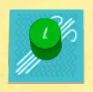

In [3]:
class Token:
    def __init__(self, game, player, current_tile):
        self.game = game
        self.player = player
        self.current_tile = current_tile
        
        self.wealth = 0
        self.route = []
        
        current_tile.move_onto_tile(self)

class Adventurer(Token):
    def __init__(self, game, player, current_tile):
        super().__init__(game, player, current_tile)
        player.adventurers.append(self)
        
        self.turns_moved = 0
    
    def move(self, compass_point):
        #placeholder for movement
        pass
        
    def explore(self, latitude, longitude):
        #placeholder for exploration
        pass
        
    def discover(self, tile):
        #placeholder for discovering new wealth
        pass
        
    def trade(self, tile):
        #placeholder for trading on a suitable tile
        pass
        
    def rest(self, agent):
        #placeholder for resting with an agent
        pass
    
    def attack(self, token):
        #placeholder for attacking other tokens in Regular and Advanced modes
        pass

### Agent tokens (x5)

These cubic tokens, which are plain on five sides and marked on the sixth with a skull'n'crossbones, can be placed in a fixed position during the game, where they will help Adventurers perform various actions like collecting extra wealth from trade or resting:
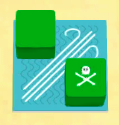

In [4]:
class Agent(Token):
    def __init__(self, game, player, current_tile):
        super().__init__(game, player, current_tile)
        player.agents.append(self)
        
    def give_rest(self, adventurer):
        #placeholder for resting adventurers
        pass
    
    def manage_trade(self, adventurer):
        #placeholder for agents involved in trade on a tile
        pass

## Items shared by all players

### Movement compass (x1)
This large circular tile contains visuals to remind players of how tokens can move during a turn or after resting. They do not play any other roles in gameplay and so are not worth simulating.
<!-- 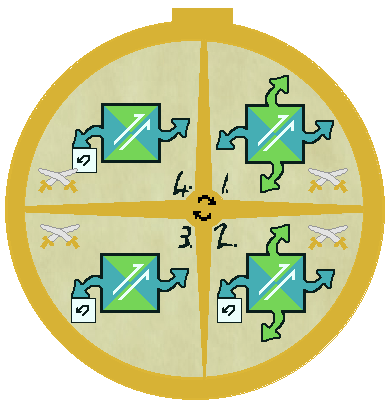 -->


### Exploration compass (x2)
This large square tile contains visuals to remind players of how tiles are rotated during exploration - for which there are currently **two variants** being tested. They do not play any other roles in gameplay and so are not worth simulating.
<!-- 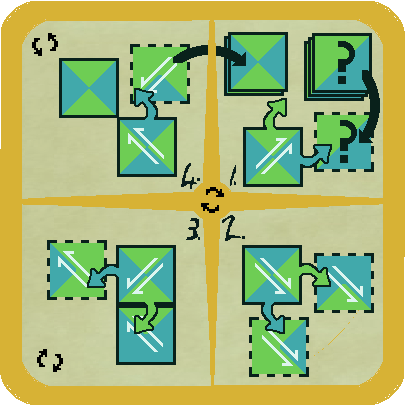 -->
<!-- 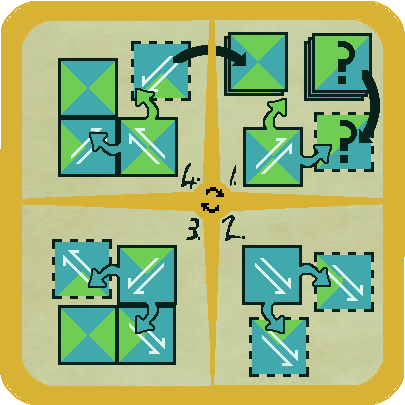 -->
<table><tr><td>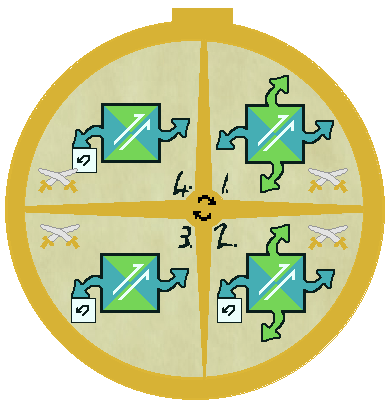</td><td>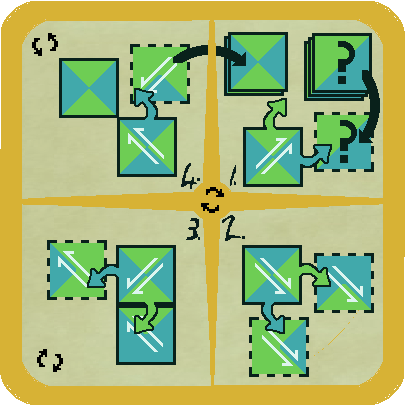</td><td>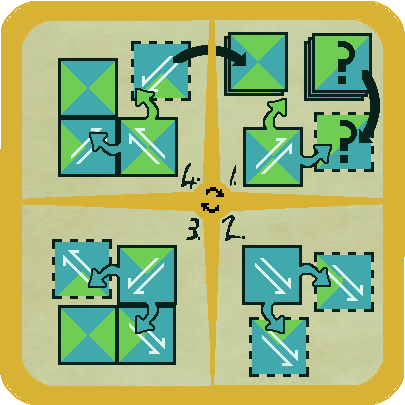</td></tr></table>

<table><tr><td colspan="3">
<font >
<h3> Conflict guide (x1) </h3>
This sheet contains visuals to remind players of how different conflicts resolve. They do not play any other roles in gameplay and so are not worth simulating. 

<h3> Pirate token (x12) </h3>
These black disc tokens, with skull'n'crossbones on both sides, are moved around with an Adventurer token once they have committed piracy, to represent the fact they have abandoned all but essential gear to aid movement at the expense of being able to present themselves in a civilised manner for trading. They do any other roles in gameplay and so are not worth simulating.
<!-- 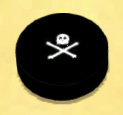 -->

<h3> Small wealth token (x50) </h3>
These many white discs each represent 1 wealth point, and would be used in the physical game to keep track of wealth collected in Adventurer's Chests, on top of Agents and Disaster tiles, and in each Player's Vault. They do not play any other roles in gameplay and so are not worth simulating. 
<!-- 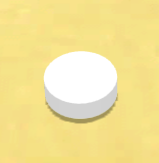 -->

<h3> Big wealth token (x50) </h3>
These many white squares each represent 5 wealth points, and would be used in the physical game to keep track of wealth collected in Adventurer's Chests, on top of Agents and Disaster tiles, and in each Player's Vault. They do not play any other roles in gameplay and so are not worth simulating. 

<h3> Gusting Wind die (x1) </h3>
This six sided die has five faces with wind arrows pointing straight to indicate wind gusting with the prevailing wind, and one face with a wind arrow curving around to indicate wind gusting against the prevailing wind. It is used in Regular game mode to allow more upwind movement and to settle conflicts.

<table><tr><td>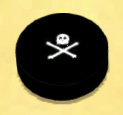</td><td>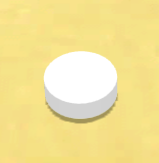</td> <td>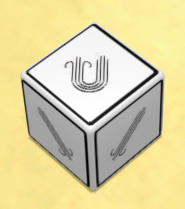</td> </tr></table>
<!-- 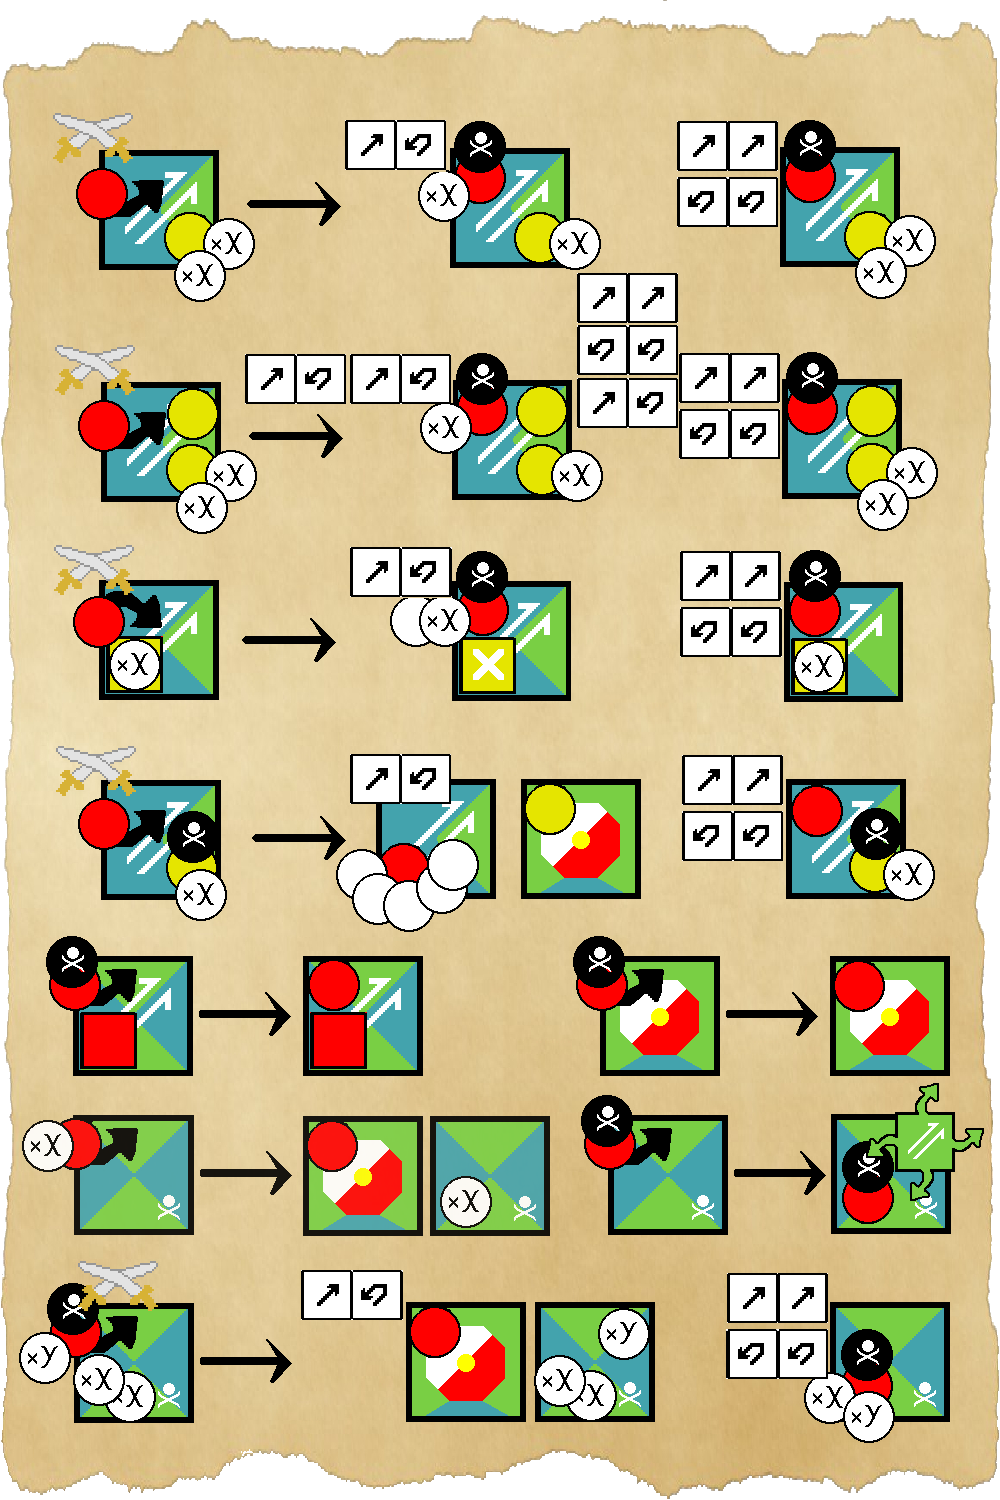 -->
</td><td colspan = "1">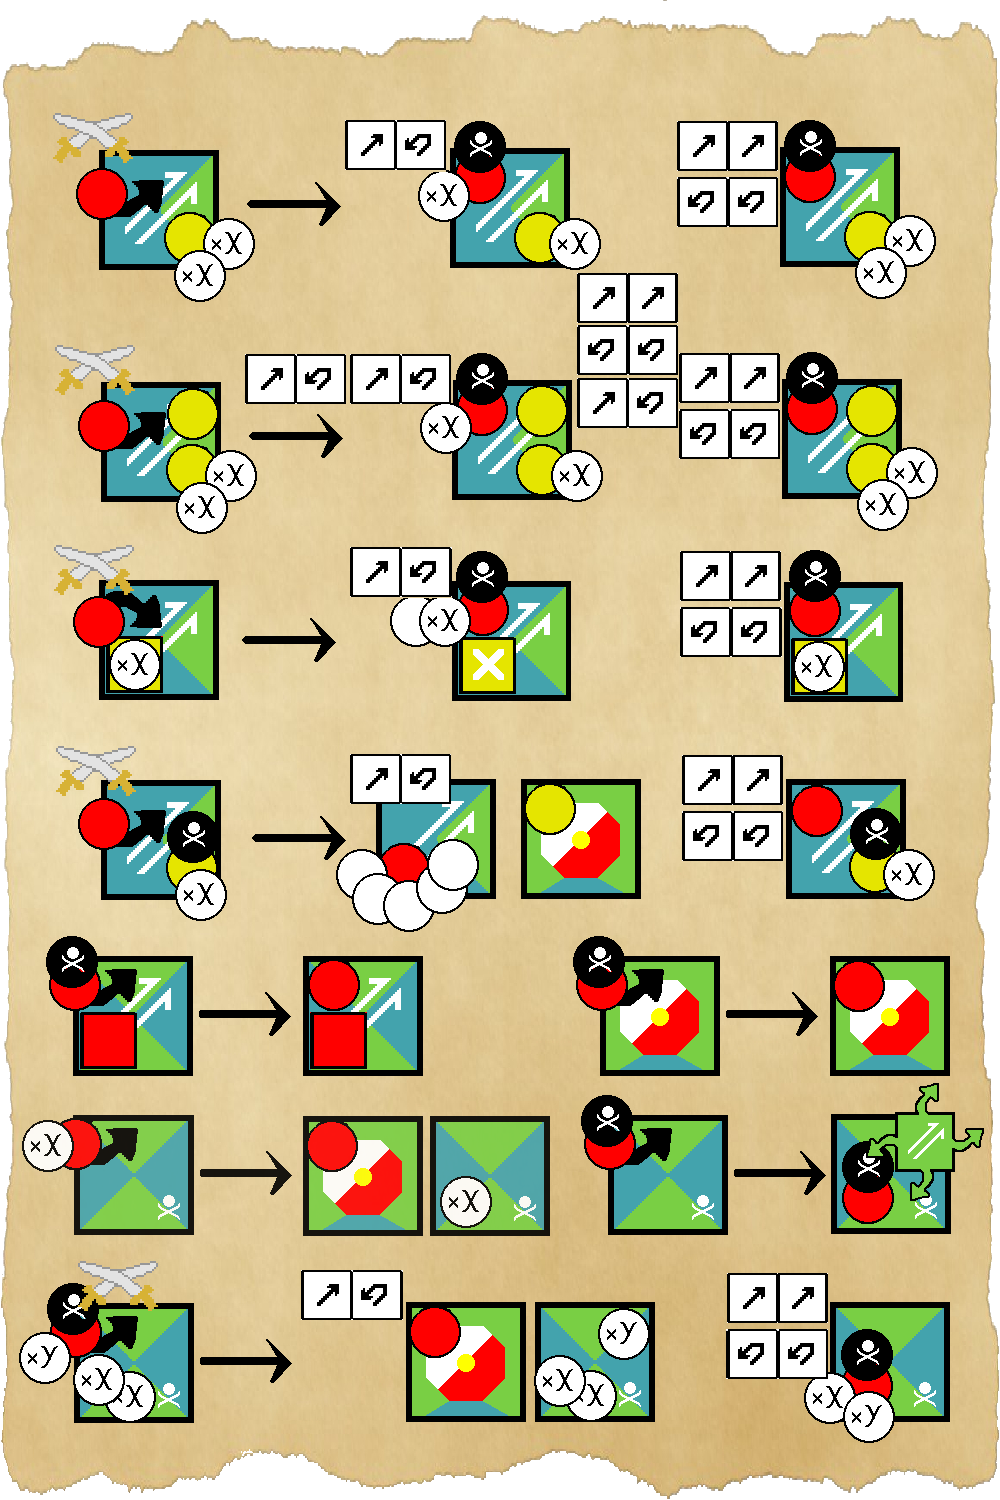</td></tr></table>


In [5]:
class GustingWindDie:
    import random
    random.seed() # defaults to system time
    
    NUM_FACES = 6
    NUM_GUST_AGAINST_WIND_FACES = 1
    
    def __init__(self, game):
        self.game = game
    
    def gust_against_wind(self):
        if random.random() < NUM_GUST_AGAINST_WIND_FACES/NUM_FACES: # careful, in Python2 integer division won't produce a float
            return True
        else:
            return False

## Tiles
The game takes place across square tiles that have been laid next to one another in a grid, drawn from tile piles, and which determine what actions players' tokens can take each movement and how they earn wealth. Each tile will have four edges that can be either water or land, and an arrow denoting wind direction diagonally across them. On the back of the tile there will be either land or water. Only water-backed tiles are used in Beginner mode. Tiles may also have a pearl/diamond denoting a Wonder on that tile or a skull'n'crossbones denoting a disaster.
<!-- 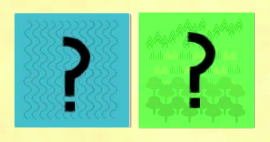  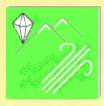  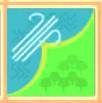 -->
<table><tr><td>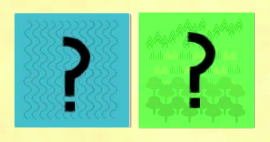</td><td>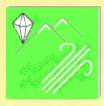</td><td>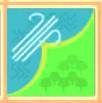</td></tr></table>

In [6]:
class TilePosition:    
    def __init__(self, latitude = None, longitude = None):
        # keep track of the tile's position in two ints
        self.latitude = latitude
        self.longitude = longitude


class WindDirection:
    def __init__(self, north = True, east = True):
        # keep track of the wind direction with two bits
        self.north = north
        self.east = east

        
class TileEdges:
    def __init__(self, uc_water = True, ua_water = True, dc_water = True, da_water = True):
        # keep track of the edges of the tile in four bits
        self.upwind_clock_water = uc_water
        self.upwind_anti_water = ua_water
        self.downwind_clock_water = dc_water
        self.downwind_anti_water = da_water


class Tile:
    def __init__(self, game
                 , tile_back = "water"
                 , wind_direction = WindDirection(True,True)
                 , tile_edges = TileEdges(True,True,True,True)
                , is_wonder = False):
        self.game = game
        self.tile_back = tile_back
        self.wind_direction = wind_direction
        self.tile_edges = tile_edges
        self.tile_position = TilePosition(None, None)
        self.is_wonder = is_wonder
        
        self.adventurers = [] # to keep track of the Adventurer tokens on a tile at any point
        self.agent = None # there can only be one Agent token on a given tile
    
    def place_tile(self, latitude, longitude):
        print("Placing tile " +str(latitude)+", "+str(longitude))
        play_area = self.game.play_area
        if play_area.get(latitude) is None:
            play_area[latitude] = {longitude:self}
            self.tile_position = TilePosition(latitude, longitude)
        elif play_area.get(latitude).get(longitude) is None: 
            play_area[latitude][longitude] = self
            self.tile_position = TilePosition(latitude, longitude)
        else: raise Exception("Tried to place a tile on top of another")
    
    def rotate_tile_clock(self):
        #NE->SE, SE->SW, SW->NW, NW->NE
        if self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.north = False
        elif not self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.east = False
        elif not self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.north = True
        elif self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.east = True
        else: raise Exception("Tile orientations have become confused")
    
    def rotate_tile_anti(self):
        #NE->NW, NW->SW, SW->SE, SE->NE
        if self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.east = False
        elif self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.north = False
        elif not self.wind_direction.north and not self.wind_direction.east:
            self.wind_direction.east = True
        elif not self.wind_direction.north and self.wind_direction.east:
            self.wind_direction.north = True
        else: raise Exception("Tile orientations have become confused")
    
    def compass_edge_water(self, compass_point):
        if self.wind_direction.north and self.wind_direction.east: # NE orientation => N = downwind anti
            if compass_point.lower() in ["north", "n"]:
                return self.tile_edges.downwind_anti_water
            elif compass_point.lower() in ["east", "e"]:
                return self.tile_edges.downwind_clock_water
            elif compass_point.lower() in ["south", "s"]:
                return self.tile_edges.upwind_anti_water
            elif compass_point.lower() in ["west", "w"]:
                return self.tile_edges.upwind_clock_water
            else: raise Exception("Tile orientations have become confused")
        elif not self.wind_direction.north and self.wind_direction.east: # SE orientation => N = upwind clock 
            if compass_point.lower() in ["north", "n"]:
                return self.tile_edges.upwind_clock_water
            elif compass_point.lower() in ["east", "e"]:
                return self.tile_edges.downwind_anti_water
            elif compass_point.lower() in ["south", "s"]:
                return self.tile_edges.downwind_clock_water
            elif compass_point.lower() in ["west", "w"]:
                return self.tile_edges.upwind_anti_water
            else: raise Exception("Tile orientations have become confused")
        elif not self.wind_direction.north and not self.wind_direction.east: # SW orientation => N = upwind anti
            if compass_point.lower() in ["north", "n"]:
                return self.tile_edges.upwind_anti_water
            elif compass_point.lower() in ["east", "e"]:
                return self.tile_edges.upwind_clock_water
            elif compass_point.lower() in ["south", "s"]:
                return self.tile_edges.downwind_anti_water
            elif compass_point.lower() in ["west", "w"]:
                return self.tile_edges.downwind_clock_water
            else: raise Exception("Tile orientations have become confused")
        elif self.wind_direction.north and not self.wind_direction.east: # NW orientation => N = downwind clock
            if compass_point.lower() in ["north", "n"]:
                return self.tile_edges.downwind_clock_water
            elif compass_point.lower() in ["east", "e"]:
                return self.tile_edges.upwind_anti_water
            elif compass_point.lower() in ["south", "s"]:
                return self.tile_edges.upwind_clock_water
            elif compass_point.lower() in ["west", "w"]:
                return self.tile_edges.downwind_anti_water
            else: raise Exception("Tile orientations have become confused")
        else: raise Exception("Tile orientations have become confused")
    
    
    def compass_edge_downwind(self, compass_point):
        if compass_point.lower() in ["north","n"]:
            return self.wind_direction.north
        elif compass_point.lower() in ["east","e"]:
            return self.wind_direction.east
        elif compass_point.lower() in ["south","s"]:
            return not self.wind_direction.north
        elif compass_point.lower() in ["west","w"]:
            return not self.wind_direction.east
        else: raise Exception("Invalid compass direction checked")
        
    
    def move_onto_tile(self, token):
        if isinstance(token, Token):
            token.current_tile = self
            if isinstance(token, Adventurer):
                print("Moving adventurer for " +str(token.player.colour)+ " player onto tile at " +str(self.tile_position.latitude)+ ", " +str(self.tile_position.longitude))
                self.adventurers.append(token)
                token.route.append(self)
                
            elif isinstance(token, Agent):
                if self.agent is None:
                    print("Moving agent for " +str(token.player.colour)+ " player onto tile at " +str(self.tile_position.latitude)+ ", " +str(self.tile_position.longitude))
                    self.agent = token
                    token.route.append(self) 
#                 elif self.agent.disabled:
#                     self.agent.current_tile = None
#                     print("Moving agent for " +str(token.player.colour)+ " player onto tile at " +str(self.tile_position.latitude)+ ", " +str(self.tile_position.longitude))
#                     self.agent = token
#                     token.route.append(self) # relevant only in Regular and Advanced mode
                else: raise Exception("Tried to add multiple Agents to a tile: adding and agent of " +token.player.colour+ " player where there was an existing agent of " +self.agent.player.colour)
            else: raise Exception("Didn't know how to handle this kind of token")
        else: raise Exception("Tried to move something other than a token onto a tile")
    
    def move_off_tile(self, token):
        if token is self.agent:
            self.agent.current_tile = None
            self.agent = None
        
        if self.adventurers.contains(token):
            self.adventurers.remove(token)
        else: raise Exception("Tried to remove a token that was never on the tile")
        

class TilePile:
    import random
    
    def __init__(self, tile_back = "water", tiles = []):
        self.tile_back = tile_back
        self.tiles = tiles
    
    def add_tile(self, tile):
        if isinstance(tile, Tile):
            if tile.tile_back == self.tile_back:
                self.tiles.append(tile)
            else: raise Exception ("Tried adding a tile to the wrong pile")
        else: raise Exception("Tried adding something other than a tile to a pile")
    
    def draw_tile(self):
        if self.tiles:
            return self.tiles.pop()
        else:
            return None
    
    def shuffle_tiles(self):
        random.shuffle(self.tiles)

### Water tiles
These tiles will tend to have more water edges, and can include Wonders that give wealth for discovery or trade, encouraging play balancing speed of travel with the time interval before banking wealth in a player's Vault.
<!-- 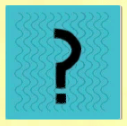 -->
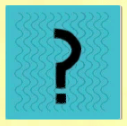

In [7]:
class WaterTile(Tile):
    tile_back = "water"
    
    def __init__(self, game, wind_direction, tile_edges, is_wonder = False):
        super().__init__(game, self.tile_back, wind_direction, tile_edges, is_wonder)

### Land tiles
These tiles will tend to have more land edges and can include both Wonders, that give wealth for discovery or trade, and Disasters, that remove all wealth from an Adventurer, encouraging play balancing risk against greater reward. 
<!-- 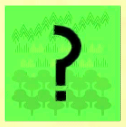 -->
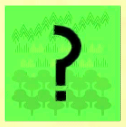

In [8]:
class LandTile(Tile):
    tile_back = "land"
    
    def __init__(self, game, wind_direction, tile_edges, is_wonder = False):
        super().__init__(game, self.tile_back, wind_direction, tile_edges, is_wonder)

### City tiles - The Capital and The Mythical City
These tiles allow players to move wealth from an Adventurer's Chest to the Player's Vault, as well as investing wealth in more Adventurers or Agents. You can move in any direction from these tiles as if every edge was land. 
<table><tr><td>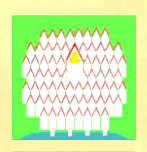</td><td>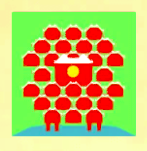</td></tr></table>
<!-- 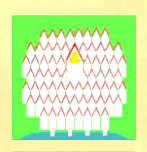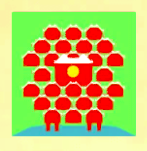 -->

In [9]:
class CityTile(LandTile):
    tile_edges = TileEdges(uc_water = False, ua_water = False, dc_water = False, da_water = False)
    wind_direction = WindDirection(True, True)
    
    def __init__(self, game, is_capital, is_discovered):
        super().__init__(game, self.wind_direction, self.tile_edges, False)
        self.is_capital = is_capital
        self.is_discovered = is_discovered
        game.cities.append(self)
    
    def visit_city(self, adventurer):
        #placeholder for interactions between an Adventurer and city
        return None
        
    def bank_wealth(self, adventurer, wealth_to_bank):
        #placeholder for letting players move wealth from an adventurer's Chest to their Vault
        return None
    
    def buy_adventurer(self, adventurer):
        #placeholder for letting players buy another Adventurer using wealth from their Vault
        return None
        
    def buy_agent(self, adventurer, tile):
        #placeholder for letting players buy another Agent using wealth from their Vault
        return None

# 2. Quick references and method definitions

## Beginner mode - Exploration and Trade by sea

### Adventurers and Movement
Adventurers start out at cities and can each move over up to 4 edges between tiles each turn, or after resting at an Agent during a turn. There are two possible variants for their movement:

1. Initial only - After their first turn, the player cannot move across a water edge (blue) against the direction of the Wind Arrow on the tile they move from. After their second move they cannot cross land edges (green).
2. Budgetted - Within these 4 moves, they can cross land edges (green) at most 2 times or can cross a water edge (blue) 1 time against the direction of the Wind Arrow on the tile they move from.

After a move onto another tile, or using a move to wait on the same tile, an Adventurer can trade as part of that same move. Resting at a player’s own Agents is free, but 1 wealth is left with another player’s Agent. 

If they are moving into an empty space with no tile, then [exploration](###-Adventurers-and-Exploration---placing-new-tiles) will be needed.

### Adventurers and Exploration - placing new tiles
When an Adventurer moves into an empty space, a new tile should be drawn to fill that space from the pile, and placed so that the edges match colour with all adjacent tiles. The wind direction should be matched, but if it doesn’t fit then there are two possible variants on how to try different rotations of the tile:

1. Clockwise first - the tile should be tried rotated clockwise, then anticlockwise.
2. Continuous wind - the tile should be tried rotated 90 degrees so that the wind arrow from their previous tile still flows into the base of the new arrow, then tried rotated 90 degrees the other way.

If the tile cannot fit with its surrounding tiles, or only with the arrow pointing in the opposite direction from the previous tile, then it is put in the discard pile and up to four more tiles tried that move.

In [10]:
class AdventurerBeginner(Adventurer):
    def __init__(self, game, player, starting_city):
        super().__init__(game, player, starting_city)
        
        print("adding an adventurer for " +str(player.colour)+ " player")
        
        self.max_exploration_attempts = game.EXPLORATION_ATTEMPTS
        self.max_downwind_moves = game.MAX_DOWNWIND_MOVES
        self.max_land_moves = game.MAX_LAND_MOVES
        self.max_upwind_moves = game.MAX_UPWIND_MOVES
        
        self.exploration_attempts = 0
        self.downwind_moves = 0
        self.upwind_moves = 0
        self.land_moves = 0
        
        self.turns_moved = 0
        self.latest_city = starting_city
        self.wonders_visited = []
    
    
    def can_move(self, compass_point): 
        # check that instruction is valid: a direction provided or an explicit general check through a None
        if compass_point is None:
            print("Adventurer is checking whether any movement at all is possible")
            if ((self.game.movement_rules == "initial" or self.game.movement_rules == "budgetted")
                and self.max_downwind_moves <= self.land_moves + self.downwind_moves + self.upwind_moves):
                return False
            for compass_point in ["n","e","s","w"]:
                if self.can_move(compass_point):
                    return True
            return False
        elif not (compass_point.lower() in ["north","n","east","e","south","s","west","w"]): 
            raise Exception("invalid direction given for movement")
        
        # check whether move is possible over the edge
        print("Adventurer is checking whether movement is possible over the " +compass_point
              + " edge from their tile at " +str(self.current_tile.tile_position.latitude)+ "," 
              + str(self.current_tile.tile_position.longitude))
        if self.game.movement_rules == "initial": #this version 1 of movement allows land and upwind movement only initially after resting
            moves_since_rest = self.land_moves + self.downwind_moves + self.upwind_moves
            print("Adventurer has determined that they have moved " +str(moves_since_rest)+ " times since resting")
            if not self.current_tile.compass_edge_water(compass_point): #land movement needed
                if(moves_since_rest < self.max_land_moves):
                    return True
            elif (self.current_tile.compass_edge_water(compass_point) 
                  and self.current_tile.compass_edge_downwind(compass_point)): #downwind movement possible
                if (moves_since_rest < self.max_downwind_moves):
                    return True
            else: #if not land or downwind, then movement must be upwind
                if(moves_since_rest < self.max_upwind_moves):
                    return True
                else: return False
        elif self.game.movement_rules == "budgetted": #this version 2 of movement allows land and upwind movement any time, but a limited number before resting
            print("Adventurer has moved " +str(self.upwind_moves)+ " times upwind, " +str(self.land_moves)+ " times overland, and " +str(self.downwind_moves)+ " times downwind, since resting")
            if not self.current_tile.compass_edge_water(compass_point): #land movement needed
                if(self.land_moves < self.max_land_moves and self.upwind_moves == 0):
                    return True
            elif (self.current_tile.compass_edge_water(compass_point) 
                  and self.current_tile.compass_edge_downwind(compass_point)): #downwind movement possible
                if (self.downwind_moves + self.land_moves + self.upwind_moves < self.max_downwind_moves):
                    return True
            else: #if not land or downwind, then movement must be upwind
                if(self.upwind_moves < self.max_upwind_moves and self.land_moves == 0):
                    return True
                else: return False
        else: raise Exception("Invalid movement rules specified")
        
    
    def exploration_needed(self, latitude, longitude):
        return self.game.play_area.get(latitude) is None or self.game.play_area.get(latitude).get(longitude) is None
        
    def choose_pile(self, compass_point):
        # establish which pile to draw from - always the water tile in beginner mode
        tile_pile = self.game.tile_piles["water"]
        print("Identifying the " +tile_pile.tile_back+ " tile pile, which still has " +str(len(tile_pile.tiles)) +" tiles")
        return tile_pile
    
    def choose_discard_pile(self, compass_point):
        # establish which pile to draw from - always the water tile in beginner mode
        discard_pile = self.game.discard_piles["water"]
        print("Identifying the " +discard_pile.tile_back+ " discard pile, which still has " +str(len(discard_pile.tiles)) +" tiles")
        return discard_pile 
    
    def move(self, compass_point):        
        moved = False
        
        # check whether the next tile exists and explore if needed, movement rules can be either "initial" or "budgetted"
        if self.can_move(compass_point):
            #include this in the number of moves so far since resting - even if exploration subsequently fails
            if not self.current_tile.compass_edge_water(compass_point): #land movement
                print("Making a land move")
                self.land_moves += 1
            elif self.current_tile.compass_edge_downwind(compass_point): #downwind movement possible
                print("Making a downwind water move")
                self.downwind_moves += 1
            else: #if not land or downwind, then movement must have been upwind
                print("Making an upwind water move")
                self.upwind_moves += 1
            
            #locate the space in the play area that the Adventurer is moving into
            latitude_increment = int(compass_point.lower() in ["east","e"]) - int(compass_point.lower() in ["west","w"])
            new_latitude = self.current_tile.tile_position.latitude + latitude_increment
            longitude_increment = int(compass_point.lower() in ["north","n"]) - int(compass_point.lower() in ["south","s"])
            new_longitude = self.current_tile.tile_position.longitude + longitude_increment

            #is this an existing tile or is exploration needed?
            if self.exploration_needed(new_latitude, new_longitude):
                # establish which pile to draw from - always the water tile in beginner mode
                tile_pile = self.choose_pile(compass_point)
                discard_pile = self.choose_discard_pile(compass_point)
                
                if self.explore(tile_pile, discard_pile, new_latitude, new_longitude, compass_point):
                    # if this is a Wonder then discovery should be automatic
#                     if isinstance(self.current_tile, WonderTile):
                    if self.current_tile.is_wonder:
                        self.discover(self.current_tile)             
                
                    #place the Adventurer on the newly placed Tile
                    self.current_tile = self.game.play_area.get(new_latitude).get(new_longitude)
                    self.current_tile.move_onto_tile(self)
                    
                    #check whether an agent can be placed and then whether the player wants to
                    self.place_agent()
                    
                    moved = True
                
            else:
                #place the Adventurer on the next existing Tile
                self.current_tile = self.game.play_area.get(new_latitude).get(new_longitude)
                self.current_tile.move_onto_tile(self)

                #check whether this is a city and remember the visit
                if isinstance(self.current_tile, CityTile):
                    self.current_tile.visit_city(self)
                
                moved = True
        
        #check whether any more moves will be possible
        if not self.can_move(None):
            print("Adventurer determined that cannot move any more, so finishing turn")
            self.turns_moved += 1
            #the adventurer will rest now before the next turn and be ready
            self.downwind_moves = 0
            self.land_moves = 0
            self.upwind_moves = 0
        
        return moved
        
    
    
    #there is always the choice to just wait in place rather than moving, to end a turn early
    def wait(self):
        print("Adventurer is choosing to wait in place")
        self.downwind_moves += 1
        
        if not self.can_move(None):
            print("Adventurer determined that cannot move any more, so finishing turn")
            self.turns_moved += 1
            #the adventurer will rest now before the next turn and be ready
            self.downwind_moves = 0
            self.land_moves = 0
            self.upwind_moves = 0

    
    def explore(self, tile_pile, discard_pile, latitude, longitude, compass_point_moving):        
        print("Exploring to the " +compass_point_moving+ " into the slot at " +str(latitude)+ "," +str(longitude)+ " which has edges...")
        
        # get the adjoining edges from the neighbouring tiles, if any
        adjoining_edge_water = {"n":None, "e":None, "s":None, "w":None}
            
        for latitude_increment in [- 1, 1]:
            if not self.game.play_area.get(latitude + latitude_increment) is None:
                neighbour_tile = self.game.play_area.get(latitude + latitude_increment).get(longitude)
                if not neighbour_tile is None:
                    #for the tile -1 latitude it will be the eastern edge that is relevant
                    if latitude_increment == -1:
                        adjoining_edge_water["w"] = neighbour_tile.compass_edge_water("east")
                    else:
                        adjoining_edge_water["e"] = neighbour_tile.compass_edge_water("west")
        for longitude_increment in [- 1, 1]:
            if not self.game.play_area.get(latitude) is None:
                neighbour_tile = self.game.play_area.get(latitude).get(longitude + longitude_increment)
                if not neighbour_tile is None:
                    #for the tile -1 longitude it will be the northern edge that is relevant
                    if longitude_increment == -1:
                        adjoining_edge_water["s"] = neighbour_tile.compass_edge_water("north")
                    else:
                        adjoining_edge_water["n"] = neighbour_tile.compass_edge_water("south")
        
        print("North: " +str(adjoining_edge_water["n"])+ ", East: " +str(adjoining_edge_water["e"])+ ", South: " +str(adjoining_edge_water["s"])+ ", West: " +str(adjoining_edge_water["w"]))
        # take multiple attempts at drawing a suitable tile from the pile
        self.exploration_attempts = 0 # this does nothing else right now...
        for attempt in range(0, self.max_exploration_attempts):
            self.exploration_attempts += 1
            if tile_pile.tiles:
                print("Drawing a tile from the " +tile_pile.tile_back+ " tile deck, which has " +str(len(tile_pile.tiles))+ " tiles")
                potential_tile = tile_pile.draw_tile()
            elif discard_pile.tiles:
                print("Have found main tile pile empty, so shuffling Discard Pile")
                game.refresh_pile(tile_pile, discard_pile)
                tile_pile = self.game.tile_piles[tile_pile.tile_back]
                discard_pile = self.game.discard_piles[discard_pile.tile_back]
                potential_tile = tile_pile.draw_tile()
            else: #the game is over, and so this exploration and the turn too
                self.turns_moved += 1
                self.game.game_over = True
                break
            print("Have drawn a tile with edges N:" +str(potential_tile.compass_edge_water("n"))
                  +";E:"+str(potential_tile.compass_edge_water("e"))
                  +";S:"+str(potential_tile.compass_edge_water("s"))
                  +";W:"+str(potential_tile.compass_edge_water("w"))
                  + " and with wind direction N:" +str(potential_tile.wind_direction.north)
                  +";E:"+str(potential_tile.wind_direction.east))
            # rotate it to the orientation of the current tile
            def null():
                pass
            while not (potential_tile.wind_direction.north == self.current_tile.wind_direction.north and 
                       potential_tile.wind_direction.east == self.current_tile.wind_direction.east):
                potential_tile.rotate_tile_clock()
            print("...after rotating to match wind, it has edges N:" +str(potential_tile.compass_edge_water("n"))
                  +";E:"+str(potential_tile.compass_edge_water("e"))
                  +";S:"+str(potential_tile.compass_edge_water("s"))
                  +";W:"+str(potential_tile.compass_edge_water("w"))
                  + " and wind direction N:" +str(potential_tile.wind_direction.north)
                  +";E:"+str(potential_tile.wind_direction.east))
            
            # check whether the tile will place, rotating as needed
            if self.game.exploration_rules == "clockwise": # this version 1 of exploration rules will just try a clockwise rotation and then an anti
                rotations = [null, potential_tile.rotate_tile_anti, potential_tile.rotate_tile_clock] # remember these will pop in reverse order, print used as a null function that will do nothing to the potential tile
            elif  self.game.exploration_rules == "continuous": # this version 2 of the exploration rules will try to line up arrows head to toe as a first preference 
                #the rotation will be anti first if and only if the wind direction is north-east or south-west and the movement is north or south
                if ((self.current_tile.wind_direction.north and self.current_tile.wind_direction.east) 
                    or (not self.current_tile.wind_direction.north and not self.current_tile.wind_direction.east)):
                    if compass_point_moving in ["n","s"]:
                        rotations = [null, potential_tile.rotate_tile_clock, potential_tile.rotate_tile_anti]
                    else:
                        rotations = [null, potential_tile.rotate_tile_anti, potential_tile.rotate_tile_clock]
                #the rotation will be anti first if and only if the wind direction is north-west or south-east and the movement is north or south
                elif (self.current_tile.wind_direction.north and not self.current_tile.wind_direction.east) or (not self.current_tile.wind_direction.north and not self.current_tile.wind_direction.east):
                    if compass_point_moving in ["n","s"]:
                        rotations = [null, potential_tile.rotate_tile_anti, potential_tile.rotate_tile_clock]
                    else:
                        rotations = [null, potential_tile.rotate_tile_clock, potential_tile.rotate_tile_anti]
                else: raise Exception("Failed to exhaust wind directions")
            
            while len(rotations) > 0:
                compass_points = ["n", "e", "s", "w"]
                edge_matches = True
                while edge_matches and len(compass_points) > 0:
                    compass_point = compass_points.pop()
                    print("checking tile matches on the " +compass_point.upper()+ ", where an adjoining edge of "
                         +str(adjoining_edge_water[compass_point])+ " must match with the tile's "
                          + str(potential_tile.compass_edge_water(compass_point)))
                    edge_matches = adjoining_edge_water[compass_point] is None or adjoining_edge_water[compass_point] == potential_tile.compass_edge_water(compass_point)

                if edge_matches:
                    # place tile and feed back to calling function that tile has been placed
                    potential_tile.place_tile(latitude, longitude)
                    return True
                else:
                    #return the tile to the same wind direction as the original
                    while not (potential_tile.wind_direction.north == self.current_tile.wind_direction.north and 
                           potential_tile.wind_direction.east == self.current_tile.wind_direction.east):
                        potential_tile.rotate_tile_anti()
                    # rotate the tile according to the alternative options in the exploration method
                    rotations.pop()()
                    print("rotated tile, so that its wind points N:" +str(potential_tile.wind_direction.north)
                         + ";E:"+ str(potential_tile.wind_direction.east))
            # discard the tile
            discard_pile.add_tile(potential_tile)
            
        # feed back to calling function that a tile has NOT been placed
        print("Exploration failed")
        self.game.num_failed_explorations += 1
        return False
            
        
    def discover(self, tile):
        #check whether this tile is inside a city's domain, four or less tiles from it by taxi norm, and just trade instead if so
        for city_tile in self.game.cities:
            city_latitude = city_tile.tile_position.latitude
            city_longitude = city_tile.tile_position.longitude
            if (abs(tile.tile_position.latitude - city_latitude) 
                + abs(tile.tile_position.longitude - city_longitude) <= self.game.CITY_DOMAIN_RADIUS):
                self.trade(tile)
                return False
        
        #award wealth
        self.wealth += self.game.VALUE_DISCOVER_WONDER["water"]
        self.wonders_visited.append(tile)
        return True
        
        
    def trade(self, tile):
        #confirm that this tile is a Wonder
#         if isinstance(tile, WonderTile):
        if not tile.is_wonder:
            return False
        
        # check that Adventurer hasn't visited this Wonder yet, since visiting a city
        if tile in self.wonders_visited:
            return False
        
        # check whether there is an Agent on the tile
        if not tile.agent is None:
            tile.agent.manage_trade(self)
        
        # collect appropriate wealth into Chest
        print("Adventurer is trading on tile " 
                  +str(tile.tile_position.latitude)+ "," +str(tile.tile_position.longitude))
        self.wealth += self.game.VALUE_TRADE
        
        # keep track of visiting this Wonder
        self.wonders_visited.append(tile)
        
        return True
    
    
    def place_agent(self):
        tile = self.current_tile
        #check whether this tile is inside a city's domain, four or less tiles from it by taxi norm, and just trade instead if so
        for city_tile in self.game.cities:
            city_latitude = city_tile.tile_position.latitude
            city_longitude = city_tile.tile_position.longitude
            if (abs(tile.tile_position.latitude - city_latitude) 
                + abs(tile.tile_position.longitude - city_longitude) <= self.game.CITY_DOMAIN_RADIUS):
                return False
        
        #check that the adventurer has requisite wealth in their Chest
        if self.wealth >= self.game.COST_AGENT_EXPLORING:

            #check whether the player actually wants to place an agent
            if len(self.player.agents) >= self.game.MAX_AGENTS:
                agent_to_move = self.player.check_move_agent(self)
                #check whether the tile already has an active Agent 
                if agent_to_move:
                    if not tile.agent is None: #extend to deal with disabled agents in Regular
                        return False
                    self.wealth -= self.game.COST_AGENT_EXPLORING
                    #pick up the Agent from its existing tile if there are no other agents available
                    #otherwise get a new agent
                    agent_to_move.current_tile.move_off_tile(agent_to_move)
                    tile.move_onto_tile(agent_to_move)
                    
                    return True
            else:
                #check whether the player actually wants to place an agent
                if self.player.check_buy_agent(self):
                    if not tile.agent is None: #extend to deal with disabled agents in Regular
                        return False
                    
                    self.wealth -= self.game.COST_AGENT_EXPLORING
                    AgentBeginner(self.game, self.player, tile)

                    return True
        return False
            
    
    def can_rest(self):
        tile = self.current_tile
        # check whether there is an agent on the tile
        if tile.agent is None:
            return False
        
        # can the adventurer afford rest here?
        if tile.agent.player == self.player or self.wealth > self.game.COST_AGENT_REST:
            return True
        else:
            return False
    
    
    def rest(self):
        tile = self.current_tile
        # check whether there is an agent on the tile
        if tile.agent is None:
            return False
        
        # use the agent if there is enough Chest wealth to
        if tile.agent.player == self.player or self.wealth >= self.game.COST_AGENT_REST:
            print("Adventurer is resting with the agent on tile " 
                  +str(tile.tile_position.latitude)+ "," +str(tile.tile_position.longitude))
            tile.agent.give_rest(self)
            return True
        else:
            return False

    
    def can_collect_wealth(self):
        tile = self.current_tile
        #check whether there is an agent on the tile
        if tile.agent is None:
            return False
        #check that the agent shares a player
        if tile.agent.player == self.player and tile.agent.wealth > 0:
            return True
        else:
            return False
        

    def collect_wealth(self):
        tile = self.current_tile
        #check whether there is an agent on the tile
        if tile.agent is None:
            return False
        #check that the agent shares a player
        if tile.agent.player == self.player:
            #transfer wealth
            print("Adventurer is collecting " +str(agent.wealth)+ " wealth from the agent on tile "
                 +str(agent.current_tile.tile_position.latitude)+","+str(agent.current_tile.tile_position.longitude))
            self.wealth += agent.wealth
            agent.wealth = 0
            return True
        else:
            return False
        
# Unit test, collects wealth from wonder tile

# Unit test, cannot place mismatched tiles - all land next to a water

# Unit test, rotation clockwise then anticlockwise returns wind direction and compass edges
# tile = Tile(Game([Player(),Player()]),wind_direction=WindDirection(True,True),tile_edges = TileEdges(True, False, False, False))
# print(str(tile.wind_direction.north)+str(tile.wind_direction.east))
# rotations = [print, tile.rotate_tile_anti, tile.rotate_tile_clock]
# print(str(tile.wind_direction.north)+str(tile.wind_direction.east))
# rotations.pop()()
# print(str(tile.wind_direction.north)+str(tile.wind_direction.east))
# print(str(tile.compass_edge_water("w")))
# rotations.pop()()
# print(str(tile.wind_direction.north)+str(tile.wind_direction.east))
# print(str(tile.compass_edge_water("w")))
# rotations.pop()()
# print(str(tile.wind_direction.north)+str(tile.wind_direction.east))

### Agents
Agents can be placed on any new tile more than four tiles from a city, costing the moving Adventurer 3 wealth. If placed on a Wonder tile, an Agent will collect 1 wealth whenever a Trade takes place on that tile, collected by the player’s next visiting Adventurer. An Agent is disabled if an opponent’s Adventurer successfully attacks it, awarding them all the wealth it was holding plus 1. An Agent is restored by its own player’s Adventurer visiting and paying 1 wealth.

In [11]:
class AgentBeginner(Agent):
    def __init__(self, game, player, tile):
        super().__init__(game, player, tile)
    
    def give_rest(self, adventurer):
        #check whether Adventurer is from same player and charge if other player
        if not adventurer.player == self.player:
            # pay as necessary
            adventurer.wealth -= 1
        
        # reset move count
        adventurer.downwind_moves = 0
        adventurer.upwind_moves = 0
        adventurer.land_moves = 0
        
        return True
    
    def manage_trade(self, adventurer):
        #check whether Adventurer trading is from the same player
        if adventurer.player == self.player:
            print("Agent on tile " +str(self.current_tile.tile_position.latitude)+","
                  +str(self.current_tile.tile_position.latitude)+ " has given monopoly bonus to Adventurer")
            # pay as necessary
            adventurer.wealth += 1
        else:
            # retain wealth if they are a different player
            print("Agent on tile " +str(self.current_tile.tile_position.latitude)+","
                  +str(self.current_tile.tile_position.latitude)+ " has kept monopoly bonus")
            self.wealth += 1
        
        return True

### Cities (Capital and Mythical): 
Within four moves of a city in any directions, Agents cannot be placed and discovering new Wonders gives no wealth. When finishing a move in a city you can move wealth from an Adventurer’s Chest into the player’s Vault, and buy another Adventurer for 10 wealth. You can also place an Agent on any tile that doesn’t have an active Agent or an opponent’s Adventurer for 5 wealth, or where you have an Adventurer for 3 wealth. Victory is awarded to the player with the most wealth in their Vault, either when one player is more than 25 ahead, or when one colour of tile runs out.

In [12]:
class CityTileBeginner(CityTile):
    
    def visit_city(self, adventurer):
        #reset Adventurer's list of visited Wonders
        adventurer.wonders = []
        
        #record that this is the latest city visited
        adventurer.latest_city = self
        
        return True
    
    
    def bank_wealth(self, adventurer, wealth_to_bank):
        #check if wealth is available and move it from the adventurer's Chest to their Vault
        if adventurer.wealth >= wealth_to_bank:
            adventurer.wealth -= wealth_to_bank
            adventurer.player.vault_wealth += wealth_to_bank
            print(adventurer.player.colour+ " player has banked " +str(wealth_to_bank)+ " in their Vault")
            self.game.check_win_conditions()
            return True
        else:
            return False
    
    def buy_adventurer(self, adventurer):
        #check that player has appropriate wealth in the Vault, and subtract if available
        if (len(adventurer.player.adventurers) < adventurer.game.MAX_ADVENTURERS 
            and adventurer.player.vault_wealth >= adventurer.game.COST_ADVENTURER):
            adventurer.player.vault_wealth -= adventurer.game.COST_ADVENTURER
            #place another Adventurer for this Player on the City tile
            new_adventurer = AdventurerBeginner(adventurer.game, adventurer.player, self)
            self.adventurers.append(new_adventurer)
            print(adventurer.player.colour+ " player has bought an adventurer from the city at " 
                  +str(self.tile_position.latitude)+","+str(self.tile_position.longitude))
            return True
        else:
            return False
        
        
    def buy_agent(self, adventurer, tile, agent_to_move):
        #check whether this tile is inside a city's domain, four or less tiles from it by taxi norm, and just trade instead if so
        for city_tile in self.game.cities:
            city_latitude = city_tile.tile_position.latitude
            city_longitude = city_tile.tile_position.longitude
            if (abs(tile.tile_position.latitude - city_latitude) 
                + abs(tile.tile_position.longitude - city_longitude) <= self.game.CITY_DOMAIN_RADIUS):
                return False
        
        #check that the player has requisite wealth in their Vault
        if adventurer.player.vault_wealth >= adventurer.game.COST_AGENT_FROM_CITY:
            #check whether the tile already has an active Agent 
            if not tile.agent is None:
                return False
            else:
                adventurer.player.vault_wealth -= adventurer.game.COST_AGENT_FROM_CITY
                #pick up the Agent from its existing tile if there are no other agents available
                #otherwise get a new agent
                if len(adventurer.player.agents)  >= self.game.MAX_AGENTS:
                    tile.move_off_tile(agent_to_move)
                    print(adventurer.player.colour+ " player is recalling their agent from the tile at " 
                      +str(agent_to_move.current_tile.tile_position.latitude)
                          +","+str(agent_to_move.current_tile.tile_position.longitude))
                else:
                    agent = AgentBeginner(adventurer.game, adventurer.player, tile)
                    
                #place the Agent on that tile
                tile.move_onto_tile(agent)
                print(adventurer.player.colour+ " player has hired an agent from the city at " 
                  +str(self.tile_position.latitude)+","+str(self.tile_position.longitude)
                     +" and sent them to the tile at "
                     +str(tile.tile_position.latitude)+","+str(tile.tile_position.longitude))
                return True


### Wonders
When turned over these tiles grant 5 wealth to the Adventurer. Subsequent visits will grant 2 wealth from Trade, but only once for each Adventurer between visits to a city.

In [13]:
# class WonderTile(Tile):
#     def __init__(game, is_wonder):
#         super().
    
#     def reward_discovery(adventurer): # This is handled in the Adventurer class atm
#         #check what kind of tile this is and look up the reward
        
#         #add wealth to Adventurer's Chest
#         pass
    
#     def reward_trade(adventurer): # This is handled in the Adventurer class atm
#         #check that adventurer has not visited this tile already since their last visit to a city
        
#         #check whether there is an active Agent on this tile and involve them in the trade if so
#         pass

# class WaterWonderTile(WonderTile)

## Regular mode - inland exploration and piracy

### Adventurers and Attacking - Piracy and Arrest
An Adventurer can attack another (non-pirate) Adventurer or Agent immediately on the tile where they finish a move. They become a pirate, then carrying the Pirate token. Until they visit a city, they cannot trade, or rest at other players’ Agents, but they can move onto and off Disaster tiles as if all the edges were land. When an Adventurer attacks another player, or tries to arrest a pirate on the same tile, they only succeed if two rolls of the die don’t match. Successful attack against an Adventurer takes half their wealth, against an Agent takes all their wealth plus one, and against a pirate removes all their wealth, returns them to their last city and awards 5 wealth to the arrester’s Vault.

### Adventurers and Inland exploration
Unlike beginner mode, when an Adventurer moves over a tile edge into an empty space, a new tile should be drawn from the pile of the same colour as that edge. When one of these tiles has Wonder, the player turning it over is rewarded with 10 wealth.

### Adventurers and upwind or unburdened movement
If an Adventurer’s Chest is empty, then they move up to three times across land edges (green) between tiles, or up to twice over water edges (blue) against the direction of the wind arrow on the tile they move from, since starting their turn or resting. After these allotted upwind moves, the player may roll a gust against the prevailing wind on the die in order to move across a water edge upwind.

In [15]:
class AdventurerRegular(AdventurerBeginner):
    def __init__(self, game, player, starting_city):
        super().__init__(game, player, starting_city)
        self.pirate_token = False
    
    def choose_pile(self, compass_point):
        # establish which pile to draw from, based on the edge being moved over from the preceding tile
        if self.current_tile.compass_edge_water(compass_point):
            return self.game.tile_piles["water"]
        else:
            return self.game.tile_piles["land"]
    
    
    def move(self, compass_point):        
        moved = False
        
        # check whether the next tile exists and explore if needed, movement rules can be either "initial" or "budgetted"
        if self.can_move(compass_point):
            #include this in the number of moves so far since resting - even if exploration subsequently fails
            if not self.current_tile.compass_edge_water(compass_point): #land movement
                print("Making a land move")
                self.land_moves += 1
            elif self.current_tile.compass_edge_downwind(compass_point): #downwind movement possible
                print("Making a downwind water move")
                self.downwind_moves += 1
            else: #if not land or downwind, then movement must have been upwind
                print("Making an upwind water move")
                self.upwind_moves += 1
            
            #locate the space in the play area that the Adventurer is moving into
            latitude_increment = int(compass_point.lower() in ["east","e"]) - int(compass_point.lower() in ["west","w"])
            new_latitude = self.current_tile.tile_position.latitude + latitude_increment
            longitude_increment = int(compass_point.lower() in ["north","n"]) - int(compass_point.lower() in ["south","s"])
            new_longitude = self.current_tile.tile_position.longitude + longitude_increment

            #is this an existing tile or is exploration needed?
            if self.exploration_needed(new_latitude, new_longitude):
                # establish which pile to draw from - always the water tile in beginner mode
                tile_pile = self.choose_pile(compass_point)
                discard_pile = self.choose_discard_pile(compass_point)
                
                if self.explore(tile_pile, discard_pile, new_latitude, new_longitude, compass_point):
                    # if this is a Wonder then discovery should be automatic
#                     if isinstance(self.current_tile, WonderTile):
                    if self.current_tile.is_wonder:
                        self.discover(self.current_tile)             
                
                    #place the Adventurer on the newly placed Tile
                    self.current_tile = self.game.play_area.get(new_latitude).get(new_longitude)
                    self.current_tile.move_onto_tile(self)
                    
                    #check whether an agent can be placed and then whether the player wants to
                    self.place_agent()
                    
                    moved = True
                
            else:
                #place the Adventurer on the next existing Tile
                self.current_tile = self.game.play_area.get(new_latitude).get(new_longitude)
                self.current_tile.move_onto_tile(self)

                #check whether this is a city and remember the visit
                if isinstance(self.current_tile, CityTile):
                    self.current_tile.visit_city(self)
                
                moved = True
        
        #check whether any more moves will be possible
        if not self.can_move(None):
            print("Adventurer determined that cannot move any more, so finishing turn")
            self.turns_moved += 1
            #the adventurer will rest now before the next turn and be ready
            self.downwind_moves = 0
            self.land_moves = 0
            self.upwind_moves = 0
        
        return moved
    
    
    def attack(self, token):
        self.pirate_token = True
        success = False
        # have opponent roll for defence, roll for attack, compare rolls
        if self.game.gusting_wind_die.gust_against_wind() != self.game.gusting_wind_die.gust_against_wind():
            success = True
        
        # resolve conflict
        # check whether adventurer or agent
        if isinstance(token, Adventurer):
            adventurer = token
            # check whether the defender adventurer is a pirate, and remove the pirate token
            if adventurer.pirate_token:
                self.pirate_token = False
                # arrest them
                if success:
                    adventurer.wealth = 0
                    self.player.vault_wealth += 5
                    adventurer.latest_city.move_onto_tile(adventurer)
            else: # rob them
                self.wealth += adventurer.wealth//2 + adventurer.wealth%2
                adventurer.wealth //= 2    
        elif isinstance(token, Agent):
            agent = token
            self.wealth += agent.wealth + 1
            agent.is_disabled = False
            agent.wealth = 0;
        else: raise Exception("Not able to deal with this kind of token.")
        
        return success


### Agents and disabling
Agents can be attacked, and if successful the attacker is awarded all the Agent's wealth plus 1 to their chest. When attacked Agents are disabled, which prevents them from giving rest to Adventurers or collecting wealth from trade on their tile. They can be revived by visiting Adventurers for 1 wealth. 

In [ ]:
class AgentRegular(AgentBeginner):
    def __init__():
        super().__init__()
        # Need to keep track of whether this Agent has been disabled
        self.is_disabled = False

### Disaster tiles
When first turned over these tiles send the moving Adventurer back to the Capital. All the wealth from their Chest is left on the tile. Half this wealth at a time can then be recovered by visiting pirates as if being attacked by the disaster.

In [34]:
class DisasterTile(Tile):
    def __init__(self, game, tile_back, wind_direction):
        super().__init__(game, tile_back, wind_direction
                         , TileEdges(False, False, False, False), False)
        self.dropped_wealth = 0
    
    def move_onto_tile(self, token):
        if isinstance(token, Token):
            if isinstance(token, Adventurer):
                # check if the Adventurer has a Pirate token
                print("Pirate moves onto disaster tile")
                if token.pirate_token:
                    super().move_onto_tile(adventurer)
                    token.player.check_attack(self) # get player input on whether to attack the disaster
                else: # otherwise send the Adventurer to the capital and keep their wealth
                    print("Adventurer moved onto disaster tile. Dropping wealth and returning to last city visited.")
                    self.dropped_wealth += token.wealth
                    token.wealth = 0
                    token.latest_city.move_onto_tile(token)
            elif isinstance(token, Agent): 
                print("Tried to add Agent to a disaster tile")
                return False
        else: raise Exception("Tried to move something other than a token onto a tile")
    
    def attack_adventurer(self, adventurer):
        # if the rolls are the same then the pirate gets helf the wealth
        if self.game.gusting_wind_die.gust_against_wind() == self.game.gusting_wind_die.gust_against_wind():
            adventurer.wealth += self.dropped_wealth//2 + self.dropped_wealth%2
        else: # otherwise send the Adventurer to the capital and keep their wealth
            self.dropped_wealth += adventurer.wealth
            adventurer.wealth = 0
            adventurer.latest_city.move_onto_tile(adventurer)

## Advanced mode - special skills, sicknesses, and seasons

# 3. Setup before play and instantiation of objects

### 1. The Capital tile is placed
The Capital tile is placed, and a plain water tile on every side of it. It is recommended that the prevailing wind should point towards the North-East on all these tiles in a 2 or 3 player game, while in a 4 player game the West and North tiles should point South-West.
<table><tr><td>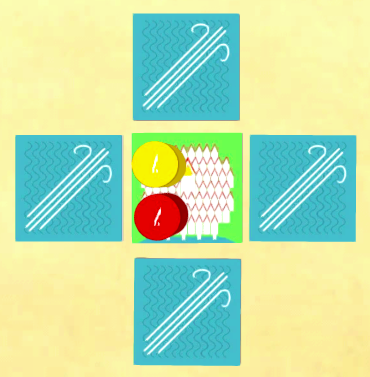</td><td>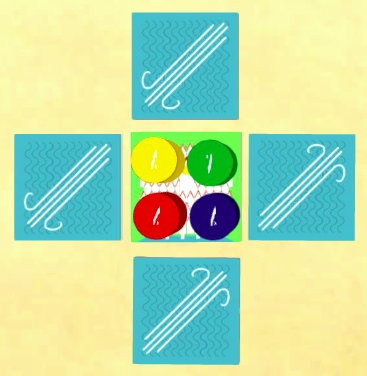</td></tr></table>

In [ ]:
def setup_simulation0(players, game_mode, movement_rules, exploration_rules):
    if not game_mode in ["Beginner", "Regular", "Advanced"]:
        raise Exception("Invalid game type specified")
    else return exec("Game" +game_mode+ "(players, movement_rules, exploration_rules)")

In [17]:
def setup_simulation1(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation0(players, game_mode, movement_rules, exploration_rules)
    
#     game = GameBeginner(players, movement_rules, exploration_rules)
    exec("CityTile" +game_mode+ "(game, True, True).place_tile(0,0)")
#     capital_tile = CityTileBeginner(game, True, True)
#     capital_tile.place_tile(0,0)
    
    #place surrounding water tiles
    if len(players) == 2:
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
    elif len(players) == 3:
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
    elif len(players) == 4:
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
         
    
    return game

### 2. Each player places an Adventurer token on the Capital tile
Each player places an Adventurer token on the Capital tile, or if they want a faster,  more unpredictable, game all can also place a second.

In [19]:
def setup_simulation2(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation1(players, game_mode, movement_rules, exploration_rules)
    
    for player in players:
#         exec("Adventurer" +game_mode+ "(game, player, game.cities[0])") #this should probably work, because it doesn't need to create a local
        print("adding an adventurer for " +str(player.colour)+ " player, who already has " +str(len(player.adventurers))+ " adventurers")
        AdventurerBeginner(game, player, game.cities[0])
    
    return game

### 3. Remaining Adventurers and Agents are placed with Player mat
Their remaining Adventurer tokens should be placed on each player's mat, in their correspondingly numbered Chests. 5 Agent tokens should be placed in the Vault.

### 4. A pile of Water Tiles is drawn
A shared pile of water tiles is randomly drawn, with 30 tiles for each player.

In [20]:
#import gspread
#from oauth2client.service_account import ServiceAccountCredentials

## use creds to create a client to interact with the Google Drive API
#scope = ['https://spreadsheets.google.com/feeds']
##scope = ['https://www.googleapis.com/auth/spreadsheets']
#creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
#client = gspread.authorize(creds)

## Find a workbook by name and open the first sheet
## Make sure you use the right name here.
#sheet = client.open("test").sheet1
#tile_distribution = sheet.col_values(1)

def setup_simulation4(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation2(players, game_mode, movement_rules, exploration_rules)
    
    import random
    
    #read in the numbers of water tiles, from google sheets?
    import csv

    tile_distribution = []
    wonder_distribution = []

    with open("tile_distribution.csv") as csvfile:
        readCSV = csv.reader(csvfile)
        for row in readCSV:
            tile_distribution.append(int(row[0]))
            wonder_distribution.append(int(row[1]))
    
    #construct the water tile deck
    row_count = 0
    tiles = []
    for uc_water in [True, False]:
        for ua_water in [True, False]:
            for dc_water in [True, False]:
                for da_water in [True, False]:
                    if uc_water or ua_water:
                        for tile_num in range(0, int(tile_distribution[row_count])-int(wonder_distribution[row_count])):
                            wind_direction = WindDirection(north = True, east = True)
                            tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
                            tiles.append(WaterTile(game, wind_direction, tile_edges, False))
                        for tile_num in range(0, int(wonder_distribution[row_count])):
                            wind_direction = WindDirection(north = True, east = True)
                            tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
                            tiles.append(WaterTile(game, wind_direction, tile_edges, True))
                        row_count += 1
    
    #draw a suitable number of tiles from the deck for a pile
    num_tiles = len(players)*game.WATER_TILES_PER_PLAYER
    tile_pile = game.tile_piles["water"]
    for tile in random.sample(tiles, num_tiles):
        tile_pile.add_tile(tile)
    
    tile_pile.shuffle_tiles()
    
    return game

# #test water tile instantiation
# row_count = 0
# game = GameBeginner(2, "initial", "clockwise")
# game.tile_piles["water"] = TilePile("water",[])
# tile_pile = game.tile_piles["water"]
# for uc_water in [True, False]:
#     for ua_water in [True, False]:
#         for dc_water in [True, False]:
#             for da_water in [True, False]:
#                 if uc_water or ua_water:
#                     for tile_num in range(0, int(tile_distribution[row_count])):
#                         tile_position = TilePosition(latitude = None, longitude = None)
#                         wind_direction = WindDirection(north = True, east = True)
#                         tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
#                         tile_pile.add_tile(WaterTile(game, tile_position, wind_direction, tile_edges))
#                     print(str(uc_water) +" "+ str(ua_water) +" "+ str(dc_water) +" "+ str(da_water) +" "+ str(tile_distribution[row_count]))
#                     row_count += 1
# print(len(game.tile_piles["water"].tiles))

### 5. A pile of Land Tiles is drawn
For Regular or Advanced mode, a shared pile of land tiles is randomly drawn, with 15 tiles for each player.

In [21]:
def setup_simulation5(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation4(players, game_mode, movement_rules, exploration_rules)
    
    import random
    
    if not game_mode in ["Regular", "Advanced"]:
        return game
    
    #read in the numbers of water and land tiles, from google sheets?
    import csv

    tile_distribution = []
    wonder_distribution = []

    with open("tile_distribution.csv") as csvfile:
        readCSV = csv.reader(csvfile)
        for row in readCSV:
            tile_distribution.append(row[0])
            wonder_distribution.append(row[1])

    #land tiles
    row_count = 12
    tiles = []
    for uc_water in [True, False]:
        for ua_water in [True, False]:
            for dc_water in [True, False]:
                for da_water in [True, False]:
                    if not uc_water or not ua_water:
                        for tile_num in range(0, int(tile_distribution[row_count])-int(wonder_distribution[row_count])):
                            wind_direction = WindDirection(north = True, east = True)
                            tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
                            tiles.append(LandTile(game, wind_direction, tile_edges, False))
                        for tile_num in range(0, int(wonder_distribution_distribution[row_count])):
                            wind_direction = WindDirection(north = True, east = True)
                            tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
                            tiles.append(LandTile(game, wind_direction, tile_edges, True))
                        row_count += 1
    
    num_tiles = len(players)*game.LAND_TILES_PER_PLAYER
    tile_pile = game.tile_piles["land"]
    for tile in random.sample(tiles, num_tiles):
        tile_pile.add_tile(tile)

    tile_pile.shuffle_tiles()    
    
    return game
                        
# #test land tile instantiation
# row_count = 12
# game = GameBeginner(2, "initial", "clockwise")
# game.tile_piles["land"] = TilePile("land",[])
# tile_pile = game.tile_piles["land"]
# for uc_water in [True, False]:
#     for ua_water in [True, False]:
#         for dc_water in [True, False]:
#             for da_water in [True, False]:
#                 if not uc_water or not ua_water:
#                     for tile_num in range(0, int(tile_distribution[row_count])):
#                         tile_position = TilePosition(latitude = None, longitude = None)
#                         wind_direction = WindDirection(north = True, east = True)
#                         tile_edges = TileEdges(uc_water, ua_water, dc_water, da_water)
#                         tile_pile.add_tile(LandTile(game, tile_position, wind_direction, tile_edges))
#                     print(str(uc_water) +" "+ str(ua_water) +" "+ str(dc_water) +" "+ str(da_water) +" "+ str(tile_distribution[row_count]))
#                     row_count += 1
# print(len(game.tile_piles["land"].tiles))

### 6. the Mythical City is placed
For 3 or 4 players, place the Mythical City tile 10 tiles east of the Capital City surrounded by four plain water tiles with the prevailing wind mirroring the Capital tile, for example pointing towards the South-West in the recommended 2/3 player setup.
<table><tr><td>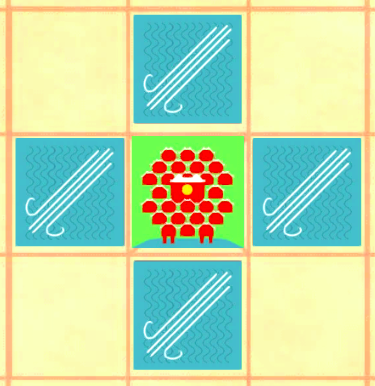</td><td>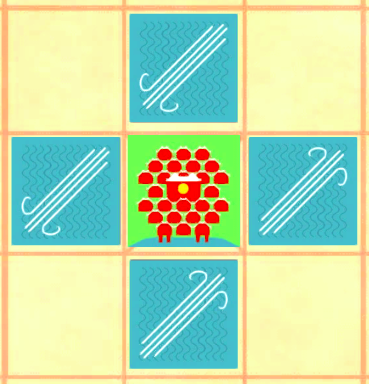</td></tr></table>

In [22]:
def setup_simulation6(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation5(players, game_mode, movement_rules, exploration_rules)

    if not game_mode in ["Regular", "Advanced"]:
        return game
    
#     exec("mythical_tile = CityTile" +game_mode+ "(game, False, False)")
#     mythical_tile.place_tile(10,0)
    exec("CityTile" +game_mode+ "(game, False, False).place_tile(10,0)")
    
    #place surrounding water tiles
    if len(players) == 2:
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
    elif len(players) == 3:
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
    elif len(players) == 4:
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(0, 1) #north
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(1, 0) #east
        WaterTile(game, WindDirection(True,True), TileEdges(True,True,True,True), False).place_tile(0, -1) #south
        WaterTile(game, WindDirection(False,False), TileEdges(True,True,True,True), False).place_tile(-1, 0) #west
    return game

### 7. Select the starting player
Starting with the youngest, players each roll the Gusting Wind die until someone gets a gust against the prevailing wind roll, which selects them as the starting player.

In [23]:
def setup_simulation(players, game_mode, movement_rules, exploration_rules):
    game = setup_simulation6(players, game_mode, movement_rules, exploration_rules)
    
    return game

# 4. Detailed instructions for play and procedural structure of game

## Visualising simulation outputs

In [24]:
class PlayAreaVisualisation:
#     import numpy as np # for managing numpy arrays
    
    # a dict in which to keep the images for tiles
    tile_image_library = {}
    
    def __init__(self, dimensions = [21, 33], origin = [15, 15]):
        import matplotlib.image as mpimg # for importing tile images
        from matplotlib import pyplot
        import os
        
        os.chdir('/home/tom/cartolan_sim')
        
        self.dimensions = dimensions
        self.origin = origin
        
        # create the grid of subplots that will form the visual 
        self.fig, self.axarr = pyplot.subplots(self.dimensions[1]+1,self.dimensions[0]+1
                                               , figsize=(30*float(dimensions[0])/float(dimensions[1]), 30))
#         self.fig, self.axarr = pyplot.subplots(self.dimensions[1]+1,self.dimensions[0]+1
#                                                , figsize=(self.dimensions[1]+1, self.dimensions[0]+1))
        
        # import tile images and establish a mapping
        if len(self.tile_image_library) == 0:
            self.tile_image_library = {}
            self.tile_image_library["water"] = mpimg.imread('./images/water.png')
            self.tile_image_library["land"] = mpimg.imread('./images/land.png')
            self.tile_image_library["water_disaster"] = mpimg.imread('./images/water_disaster.png') 
            self.tile_image_library["land_disaster"] = mpimg.imread('./images/land_disaster.png') 
            self.tile_image_library["capital"] = mpimg.imread('./images/capital.png') 
            self.tile_image_library["mythical"] = mpimg.imread('./images/mythical.png') 
            for uc_water in [True, False]: 
                for ua_water in [True, False]:
                    for dc_water in [True, False]:
                        for da_water in [True, False]:
                            for wonder in [True, False]:
                                filename = ""
                                if uc_water:
                                    filename += "t"
                                else:
                                    filename += "f"
                                if ua_water:
                                    filename += "t"
                                else:
                                    filename += "f"
                                if dc_water:
                                    filename += "t"
                                else:
                                    filename += "f"
                                if da_water:
                                    filename += "t"
                                else:
                                    filename += "f"
                                if wonder:
                                    filename += "t"
                                else:
                                    filename += "f"

                                self.tile_image_library[str(uc_water)+str(ua_water)+str(dc_water)+str(da_water)
                                                        +str(wonder)] = mpimg.imread('./images/' +filename+ '.png')
        
    
    # convert the play_area to a grid of tiles
    def draw_play_area(self, play_area):
        from matplotlib import pyplot # for plotting the tiles in a grid
        from scipy import ndimage # for rotating tiles
        import numpy

        for latitude in play_area:
            if self.origin[0] + latitude in range(0, self.dimensions[0]+1):
                for longitude in play_area[latitude]:
                    if self.origin[1] + longitude in range(0, self.dimensions[1]+1):
                        #bring in the relevant image from the library
                        tile = play_area[latitude][longitude]
                        e = tile.tile_edges
                        if isinstance(tile, CityTile):
                            if tile.is_capital:
                                tile_image = self.tile_image_library["capital"]
                            else:
                                tile_image = self.tile_image_library["mythical"]
                        elif isinstance(tile, DisasterTile):
                            if tile.tile_back == "water":
                                tile_image = self.tile_image_library["water_disaster"]
                            else:
                                tile_image = self.tile_image_library["land_disaster"]
                        else:
                            wonder = tile.is_wonder
                            tile_image = self.tile_image_library[str(e.upwind_clock_water)+str(e.upwind_anti_water)
                                                                 +str(e.downwind_clock_water)+str(e.downwind_anti_water)
                                                                 +str(wonder)]            

                        #rotate the image appropriately
                        if not tile.wind_direction.north and tile.wind_direction.east:
                            rotated_image = ndimage.rotate(tile_image, 270)
                        elif not tile.wind_direction.north and not tile.wind_direction.east:
                            rotated_image = ndimage.rotate(tile_image, 180)
                        elif tile.wind_direction.north and not tile.wind_direction.east:
                            rotated_image = ndimage.rotate(tile_image, 90)
                        else:
                            rotated_image = ndimage.rotate(tile_image, 0)

                        #place the tile image in the grid
                        horizontal = origin[0] + latitude
                        vertical = dimensions[1] - origin[1] - longitude
#                         print(str(vertical)+","+str(horizontal))
#                         title_loc = str(latitude)+","+str(longitude)
#                         self.axarr[vertical, horizontal].imshow(rotated_image, interpolation='nearest')
                        self.axarr[vertical, horizontal].imshow((rotated_image * 255).astype(numpy.uint8), interpolation='nearest')

        #remove axes
        for horizontal in range(0, self.dimensions[0]+1):
            for vertical in range(0, self.dimensions[1]+1):
                self.axarr[vertical, horizontal].axis('off')

#         self.pyplot.show()
        return True
    
    def update_play_area(self, play_area):
        

    # it will be useful to see how players moved around the play area during the game, and relative to agents
    def draw_routes(self, players):
        #try to set up a new master axes spanning all the subplots
        overax = self.fig.add_subplot(111)
        overax.plot([5,5],[0,1],'--')
        
        for player in players:
            for adventurer in player.adventurers:
                previous_step = self.origin
                # we'll introduce a gradual offset during the course of the game, to help keep track of when a route was travelled
                previous_offset = 0.25
                move = 0
                for tile in adventurer.route:
                    # plot() to draw a line between two points. Call matplotlib. pyplot. plot(x, y) with x as a list of x-values and y as a list of their corresponding y-values of two points to plot a line segment between them.
                    # you'll need to get the centre-point for each tile_image
                    offset = 0.25 + float(move)/float(len(adventurer.route))*0.5
                    step = [self.origin[0] + tile.tile_position.latitude, self.origin[1] + tile.tile_position.longitude]
#                     self.fig.add_axes(rect=[1.0,1.0]).plot([previous_step[0]+0.5,step[0]+0.5],[previous_step[1]+0.5,step[1]+0.5]
#                                   , color=player.colour)
                    overax.plot([previous_step[0]+previous_offset,step[0]+offset],[previous_step[1]+previous_offset,step[1]+offset]
                                  , color=player.colour, linewidth=round(10.0*offset))
                    previous_step = step
                    previous_offset = offset
                    move += 1
            
            for agent in player.agents: 
                for tile in agent.route:
                    # we want to draw a square anywhere that an agent is
                    # do we also want a marker where agents have previously been?
                    if tile == agent.route[-1]:
                        face_colour = player.colour
                    else:
                        face_colour = "none"
                    location = [self.origin[0] + tile.tile_position.latitude
                                , self.origin[1] + tile.tile_position.longitude]
                    overax.scatter([location[0]+0.75],[location[1]+0.25]
                                  , edgecolors=player.colour, facecolor=face_colour, marker="s", s=400.0)
        
        overax.set_ylim([0,dimensions[1]+1])
        overax.set_xlim([0,dimensions[0]+1])
        overax.axis("off")
        

    
class PlayStatsVisualisation:
    import pandas
    from matplotlib import pyplot
    
    def __init__(self, play_stats):
        self.play_stats = play_stats
        self.fig = self.pyplot.figure(figsize=(20,30) )
    
    def win_type_comparison(self):
        # win counts for different win conditions
        ax = self.fig.add_subplot(321, title="#Wins by win condition")
        ax = self.pyplot.hist(self.play_stats["win_type"])
    
    def turns_to_win(self):
        # win counts for different numbers of turns to win
        ax = self.fig.add_subplot(322, title="#Wins by # turns to win")
        ax = self.pyplot.hist(self.play_stats["turns"])
    
    def player_type_comparison(self):
        # win counts for different player types
        ax = self.fig.add_subplot(323, title="#Wins by winning player type")
        ax = self.pyplot.hist(self.play_stats["winning_player_type"])
    
    def player_order_comparison(self):
        # win counts for different player starting positions
        ax = self.fig.add_subplot(324, title="#Wins by winner's position in play order")
        ax = self.pyplot.hist(self.play_stats["winning_player_order"])
    
    def wealth_comparison(self):
        # distribution of winning player wealth vs average wealth across games
#         self.play_stats["max_wealth_share"] = self.play_stats["max_wealth_final"!=0]["max_wealth_final"]/self.play_stats[["wealth_p1", "wealth_p2", "wealth_p3", "wealth_p4"]].sum(axis=1)
        self.play_stats["max_wealth_share"] = self.play_stats["max_wealth_final"]/self.play_stats[["wealth_p1", "wealth_p2", "wealth_p3", "wealth_p4"]].sum(axis=1)
        ax = self.fig.add_subplot(325, title="#Wins by winner's share of total vault wealth")
        ax = self.pyplot.hist(self.play_stats["max_wealth_share"])
    
    def route_comparison(self):
        # distribution of winning player route length vs average route length across games
        self.play_stats["avg_route_share"] = self.play_stats["winning_player_route"]/self.play_stats[["avg_route_p1", "avg_route_p2", "avg_route_p3", "avg_route_p4"]].sum(axis=1)
        ax = self.fig.add_subplot(326, title="#Wins by winner's share of total moves travelled")
        ax = self.pyplot.hist(self.play_stats["avg_route_share"])
        
#     def agent_comparison(self):
#         # distribution of final agent numbers
#         ax = self.fig.add_subplot(324, title="#Wins by winner's final number of agents")
#         ax = self.pyplot.hist(self.play_stats[""])
        
#     def adventurer_comparison(self):

## Simulating Beginner mode

### Game rules

In [25]:
class GameBeginner(Game):    
    GAME_WINNING_DIFFERENCE = 25
    
    MAX_ADVENTURERS = 3
    MAX_AGENTS = 5
    
    WATER_TILES_PER_PLAYER = 30
    
    VALUE_DISCOVER_WONDER = {"water":5}
    VALUE_TRADE = 2
    VALUE_AGENT_TRADE = 1
    
    COST_ADVENTURER = 10
    COST_AGENT_EXPLORING = 3
    COST_AGENT_FROM_CITY = 5
    COST_AGENT_REST = 1
    
    EXPLORATION_ATTEMPTS = 5
    MAX_DOWNWIND_MOVES = 4
    MAX_LAND_MOVES = 2
    MAX_UPWIND_MOVES = 1    
    
    CITY_DOMAIN_RADIUS = MAX_DOWNWIND_MOVES
    
    def __init__(self, players, movement_rules = 'initial', exploration_rules = 'clockwise'):
        
        super().__init__(players)
        
        if movement_rules in ["initial", "budgetted"]:
            self.movement_rules = movement_rules
        else: raise Exception("Invalid movement rules specified")
        
        if exploration_rules in ["clockwise", "continuous"]:
            self.exploration_rules = exploration_rules
        else: raise Exception("Invalid exploration rules specfied")
        
        self.cities = []

        self.tile_piles = {"water":TilePile("water",[])}
        self.discard_piles = {"water":TilePile("water",[])}
        
        self.win_type = None
        
    
    def start_game(self):
        game_over = False
        while not game_over:
            self.turn += 1
            game_over = self.play_round()
        
        #report game conclusion to caller
        return True
    
    
    def refresh_pile(self, tile_pile, discard_pile):
        #check whether the discard pile is empty too
        if discard_pile.tiles:
            self.tile_piles.pop(tile_pile.tile_back)
            self.tile_piles[tile_pile.tile_back] = discard_pile
            tile_pile = self.tile_piles[tile_pile.tile_back]
            discard_pile.shuffle_tiles()
            print("Have replaced the main tile pile with the discard pile, and shuffled it,"
                  +" so that now there are " +str(len(self.tile_piles))+ " tile piles.")
            #Start a new discard pile
            self.discard_piles.pop(discard_pile.tile_back)
#             self.discard_piles[discard_pile.tile_back] = TilePile(discard_pile.tile_back)
            self.discard_piles["water"] = TilePile("water",[])
            discard_pile = self.discard_piles[discard_pile.tile_back]
            print("Have started a new discard pile, so that now there are "
                 + str(len(self.discard_piles))+ " discard piles.")
            return True
        else:
            self.check_win_conditions() #try and exit here if so
            return False
    
    def play_round(self):
        print("playing round "+str(self.turn)+" with a wealth difference of " +str(self.wealth_difference) 
             +" and a max wealth of " +str(self.max_wealth))
        for player in players:
            #some logging
            print(str(player.colour)+ " player's turn, with " +str(len(player.adventurers)) 
                  +" Adventurers, and " +str(player.vault_wealth)+ " wealth in the Vault")
#             if not player.adventurers[0] is None:
#                 adventurer = player.adventurers[0]
#                 adventurer_tile = adventurer.current_tile
#                 print("And their first Adventurer has " +str(adventurer.wealth)+ " wealth, and is on the " +adventurer_tile.tile_back+  " tile at position " +str(adventurer_tile.tile_position.latitude)+ "," +str(adventurer_tile.tile_position.longitude))
            
            # a more sophisticated simulation might need to let players choose their Adventurers' turn order first
            
            # let players move an adventurer so long as it still has valid moves
            for adventurer in player.adventurers:
                if adventurer.turns_moved < self.turn:
                    player.continue_turn(adventurer)
                    print() #to help log readability
                    
                    #check whether this adventurer's turn has won them the game
                    if self.check_win_conditions():
                        return True
        
        #log the numbers of tiles remaining in the game
        for tile_back in self.tile_piles.keys():
            tile_pile = self.tile_piles[tile_back]
            discard_pile = self.discard_piles[tile_back]
            print(str(len(tile_pile.tiles))+" "+tile_back+" tiles left in the main pile and " +str(len(discard_pile.tiles))+" left in the discard pile")
            print() #to help log readability
            print() #to help log readability
            
    
    def check_win_conditions(self):
        #the end conditions for a game are one player having a certain margin more wealth in their Vault, or one of the tile piles being emptied
        self.max_wealth = 0
        self.wealth_difference = 0
        for player in self.players:
            # is this player wealthier than the wealthiest player checked so far?
            if player.vault_wealth > self.max_wealth:
                self.wealth_difference = player.vault_wealth - self.max_wealth
                self.max_wealth = player.vault_wealth
                self.winning_player = player
            # if this player is behind in wealth, are they still closer than anyone else?
            elif self.max_wealth - player.vault_wealth < self.wealth_difference:
                    self.wealth_difference = self.max_wealth - player.vault_wealth

        if self.wealth_difference > self.GAME_WINNING_DIFFERENCE:
            print("won by wealth difference")
            self.win_type = "wealth difference"
            self.game_over = True
            return True

        for tile_pile in self.tile_piles.values():
            if not tile_pile.tiles and not self.discard_piles[tile_pile.tile_back].tiles:
                print("won by running out of tiles")
                if self.winning_player:
                    self.win_type = "exhausted " +tile_pile.tile_back+ " tiles"
                else:
                    self.win_type = "tiles exhausted but no player banked wealth"
                    max_chest_wealth = 0
                    for player in self.players:
                        for adventurer in player.adventurers:
                            if adventurer.wealth > max_chest_wealth:
                                self.winning_player = player
                                max_chest_wealth = adventurer.wealth
                self.game_over = True
                return True
        
        return False

In [33]:
class GameRegular(GameBeginner):
    # in Regular mode agents can be disabled and restored through piracy, with rewards and costs
    VALUE_DISABLE_AGENT = 1
    COST_AGENT_RESTORE = 1
        
    def __init__(self, players, movement_rules = 'initial', exploration_rules = 'clockwise'):
        super().__init__(players, movement_rules = 'initial', exploration_rules = 'clockwise')
        # a land tile pile is now needed
        tile_piles["land"] = TilePile("land",[])
        discard_piles["land"] = TilePile("land",[])      
        
        # a Gusting Wind die is now needed
        gusting_wind_die = GustingWindDie(self)

### Player behaviours

In [28]:
class PlayerBeginnerExplorer(Player):    
# this crude computer player will always move away from the Capital while its Chest has less than the points difference and then towards the Capital once it has collected enough wealth
# if it can't move away from the Capital as desired, but can move, it will avoid the clockwise rotation of the wind, by heading downwind to the left
# if it can't move toward the Capital as desired, but can move, it will make use of the clockwise rotation of the wind, by heading downwind to the right
    def get_wind_swinging_compass(self, adventurer, intent="swing"):
        # the best chance of swinging the wind will be moving in the righthand downwind direction 
        wind_direction = adventurer.current_tile.wind_direction
        if wind_direction.north and wind_direction.east:
            if intent == "swing":
                return "e"
            else:
                return "n"
        elif not wind_direction.north and wind_direction.east:
            if intent == "swing":
                return "s"
            else:
                return "e"
        elif not wind_direction.north and not wind_direction.east:
            if intent == "swing":
                return "w"
            else:
                return "s"
        else:
            if intent == "swing":
                return "n"
            else:
                return "w"
        
        
    def move_away_from_tile(self, adventurer, tile):
        print(str(adventurer.player.colour) +": want to move away from the tile at " +str(tile.tile_position.latitude)+ ", " +str(tile.tile_position.latitude))
        #establish directions to Capital (assumed at 0,0), as preferring to increase the distance in the lesser dimension first, between longitude and latitude
        if (abs(adventurer.current_tile.tile_position.latitude - tile.tile_position.latitude) 
            > abs(adventurer.current_tile.tile_position.longitude - tile.tile_position.longitude)):
            if adventurer.current_tile.tile_position.longitude > tile.tile_position.longitude:
                if adventurer.move("n"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if adventurer.move("s"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude-1])
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.latitude >= tile.tile_position.latitude:
                if adventurer.move("e"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                    ,adventurer.current_tile.tile_position.longitude])
            else:
                if adventurer.move("w"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude-1
                                                    ,adventurer.current_tile.tile_position.longitude])
        else:
            if adventurer.current_tile.tile_position.latitude >= tile.tile_position.latitude:
                if adventurer.move("e"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                    ,adventurer.current_tile.tile_position.longitude])
            else:
                if adventurer.move("w"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude-1
                                                    ,adventurer.current_tile.tile_position.longitude])
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.longitude > tile.tile_position.longitude:
                if adventurer.move("n"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if adventurer.move("s"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude-1])
        #with no moves away possible, it's best to avoid swinging the wind by heading downwind and left
        wind_keeping_compass = self.get_wind_swinging_compass(adventurer, intent="keep")
        if adventurer.move(wind_keeping_compass):
            return True
        else:
            return adventurer.wait()

    # a similar heuristic, but with a preference for exploration whenever possible
    def explore_away_from_tile(self, adventurer, tile):
        print(str(adventurer.player.colour) +": want to move away from the tile at " +str(tile.tile_position.latitude)+ ", " +str(tile.tile_position.latitude))
        #establish directions to Capital (assumed at 0,0), as preferring to increase the distance in the lesser dimension first, between longitude and latitude
        if (abs(adventurer.current_tile.tile_position.latitude - tile.tile_position.latitude) 
            > abs(adventurer.current_tile.tile_position.longitude - tile.tile_position.longitude)):
            if adventurer.current_tile.tile_position.longitude > tile.tile_position.longitude:
                if (adventurer.can_move("n") 
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude
                                                      , adventurer.current_tile.tile_position.longitude+1)):
                    if adventurer.move("n"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                        ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if (adventurer.can_move("s")
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude
                                                      , adventurer.current_tile.tile_position.longitude-1)):
                    if adventurer.move("s"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                        ,adventurer.current_tile.tile_position.longitude-1])
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.latitude >= tile.tile_position.latitude:
                if (adventurer.can_move("e") 
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude+1
                                                      , adventurer.current_tile.tile_position.longitude)):
                    if adventurer.move("e"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                        ,adventurer.current_tile.tile_position.longitude])
            else:
                if (adventurer.can_move("w") 
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude-1
                                                      , adventurer.current_tile.tile_position.longitude)):
                    if adventurer.move("w"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude-1
                                                        ,adventurer.current_tile.tile_position.longitude])
        else:
            if adventurer.current_tile.tile_position.latitude >= tile.tile_position.latitude:
                if (adventurer.can_move("e")
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude+1
                                                      , adventurer.current_tile.tile_position.longitude)):
                    if adventurer.move("e"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                        ,adventurer.current_tile.tile_position.longitude])
            else:
                if (adventurer.can_move("w")
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude-1
                                                      , adventurer.current_tile.tile_position.longitude)):
                    if adventurer.move("w"):
                        return True
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.longitude > tile.tile_position.longitude:
                if (adventurer.can_move("n")
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude
                                                      , adventurer.current_tile.tile_position.longitude+1)):
                    if adventurer.move("n"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                        ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if (adventurer.can_move("s")
                    and adventurer.exploration_needed(adventurer.current_tile.tile_position.latitude
                                                      , adventurer.current_tile.tile_position.longitude-1)):
                    if adventurer.move("s"):
                        return True
                    else:
                        self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                        ,adventurer.current_tile.tile_position.longitude-1])
        #with no exploration away possible, try movement onto existing tiles
        return self.move_away_from_tile(adventurer, tile)
            
    def move_towards_tile(self, adventurer, tile):
        print(str(adventurer.player.colour) +": want to move towards the tile at " +str(tile.tile_position.latitude)+ ", " +str(tile.tile_position.latitude))
        #establish directions to Capital (assumed at 0,0), as preferring to decrease the distance in the greater dimension first, between longitude and latitude
        if (abs(adventurer.current_tile.tile_position.latitude - tile.tile_position.latitude) 
            < abs(adventurer.current_tile.tile_position.longitude - tile.tile_position.longitude)):
            if adventurer.current_tile.tile_position.longitude < tile.tile_position.longitude:
                if adventurer.move("n"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if adventurer.move("s"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude-1])
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.latitude <= tile.tile_position.latitude:
                if adventurer.move("e"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                    ,adventurer.current_tile.tile_position.longitude])
            else:
                if adventurer.move("w"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude-1
                                                    ,adventurer.current_tile.tile_position.longitude])
        else:
            if adventurer.current_tile.tile_position.latitude <= tile.tile_position.latitude:
                if adventurer.move("e"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude+1
                                                    ,adventurer.current_tile.tile_position.longitude])
            else:
                if adventurer.move("w"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude-1
                                                    ,adventurer.current_tile.tile_position.longitude])
            #without the preferred move available, try the other dimension
            if adventurer.current_tile.tile_position.longitude < tile.tile_position.longitude:
                if adventurer.move("n"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude+1])
            else:
                if adventurer.move("s"):
                    return True
                else:
                    self.locations_to_avoid.append([adventurer.current_tile.tile_position.latitude
                                                    ,adventurer.current_tile.tile_position.longitude-1])
        #with no moves away from Capital possible, it's time to try swinging the wind by heading downwind and right
        print("Can't move in desired direction so trying to get a favourable wind direction")
        wind_swinging_compass = self.get_wind_swinging_compass(adventurer, intent="swing")
        if adventurer.move(wind_swinging_compass):
            return True
        else:
            return adventurer.wait()
    
        
    def continue_turn(self, adventurer):
        import random
        print(str(adventurer.player.colour)+ " player is moving an Adventurer, which has " 
              +str(adventurer.wealth)+ " wealth, and is on the "
              +adventurer.current_tile.tile_back+ " tile at position " 
              +str(adventurer.current_tile.tile_position.latitude)+ "," 
              +str(adventurer.current_tile.tile_position.longitude))

        while adventurer.turns_moved < adventurer.game.turn:
            #with some probability, move in a random direction, to break out of degenerate situations
            if random.random() < self.p_deviate:
                adventurer.move(random.choice(['n','e','s','w']))
            
            for city in adventurer.game.cities: #locate the capital tile
                if city.is_capital:
                    capital_tile = city
            #move towards the capital while banking will put the player ahead, and explore otherwise
            if(adventurer.wealth > adventurer.game.wealth_difference):
                self.move_towards_tile(adventurer, capital_tile)
            else:
                self.explore_away_from_tile(adventurer, capital_tile)

            #if this is a wonder then always trade
#             if isinstance(adventurer.current_tile, WonderTile):
            if adventurer.current_tile.is_wonder:
                adventurer.trade(adventurer.current_tile) 

            #if this is a city then always bank everything
            if isinstance(adventurer.current_tile, CityTile):
                adventurer.current_tile.bank_wealth(adventurer, adventurer.wealth)
                #check whether oponents will win on their next visit to a city, and buy an adventurer if not
                if self.vault_wealth > adventurer.game.COST_ADVENTURER:
                    opponent_near_win = False
                    for player in adventurer.game.players:
                        player_chest_wealth = 0
                        for other_adventurer in player.adventurers:
                            player_chest_wealth += other_adventurer.wealth
                        if (player.vault_wealth + player_chest_wealth 
                            > adventurer.game.GAME_WINNING_DIFFERENCE - adventurer.game.wealth_difference):
                            opponent_near_win = True
                    if not opponent_near_win:
                        adventurer.current_tile.buy_adventurer(adventurer)
        
        return True
    
    # never place an agent when offered
    def check_buy_agent(self, adventurer):
#         return True
        return False
    
    # never move an agent when offered
    def check_move_agent(self, adventurer):     
#         return agent_to_move
        return False


class PlayerBeginnerTrader(PlayerBeginnerExplorer):    
# this crude computer player will always move away from the Capital while its Chest has less than the points difference and then towards the Capital once it has collected enough wealth
# if it can't move away from the Capital as desired, but can move, it will avoid the clockwise rotation of the wind, by heading downwind to the left
# if it can't move toward the Capital as desired, but can move, it will make use of the clockwise rotation of the wind, by heading downwind to the right
# unlike the crude explorer, it will establish agents whenever it discovers a wonder
    def __init__(self, colour):
        super().__init__(colour)
        self.next_agent_number = 0
    
    def continue_turn(self, adventurer):
        import random
        print(str(adventurer.player.colour)+ " player is moving an Adventurer, which has " 
              +str(adventurer.wealth)+ " wealth, and is on the "
              +adventurer.current_tile.tile_back+ " tile at position " 
              +str(adventurer.current_tile.tile_position.latitude)+ "," 
              +str(adventurer.current_tile.tile_position.longitude))
        while adventurer.turns_moved < adventurer.game.turn:
            #with some probability, move in a random direction, to break out of degenerate situations
            if random.random() < self.p_deviate:
                adventurer.move(random.choice(['n','e','s','w']))
                                
            #locate the capital tile
            for city in adventurer.game.cities:
                if city.is_capital:
                    capital_tile = city
            #locate the next unvisited agent and move towards them, or if all agents have been visited either explore or return home
            if not self.next_agent_number < len(self.agents):
                if (adventurer.wealth <= adventurer.game.wealth_difference
                    and len(self.agents) < adventurer.game.MAX_AGENTS
                   ):
                    self.explore_away_from_tile(adventurer, capital_tile)
                else:
                    self.move_towards_tile(adventurer, capital_tile)
            else:
                if adventurer.wealth <= adventurer.game.wealth_difference:
                    self.move_towards_tile(adventurer, self.agents[self.next_agent_number].current_tile)
                else:
                    self.move_towards_tile(adventurer, capital_tile)

            #if this is a wonder then always trade, and if it has an agent then rest
#             if isinstance(adventurer.current_tile, WonderTile):
            if adventurer.current_tile.is_wonder:
                adventurer.trade(adventurer.current_tile)

            #if there is an agent then always rest
            agent = adventurer.current_tile.agent
            if not agent is None:
                adventurer.rest()
                if self.next_agent_number < len(self.agents):
                    if agent == self.agents[self.next_agent_number]:
                        #start targetting the next agent
                        self.next_agent_number += 1

            #if this is a city then always bank everything and get ready to visit the agents again
            if isinstance(adventurer.current_tile, CityTile):
                adventurer.current_tile.bank_wealth(adventurer, adventurer.wealth)
                self.next_agent_num = 0
                #check whether oponents will win on their next visit to a city, and buy an adventurer if not
                if self.vault_wealth > adventurer.game.COST_ADVENTURER:
                    opponent_near_win = False
                    for player in adventurer.game.players:
                        player_chest_wealth = 0
                        for other_adventurer in player.adventurers:
                            player_chest_wealth += other_adventurer.wealth
                        if (player.vault_wealth + player_chest_wealth 
                            > adventurer.game.GAME_WINNING_DIFFERENCE - adventurer.game.wealth_difference):
                            opponent_near_win = True
                    if not opponent_near_win:
                        adventurer.current_tile.buy_adventurer(adventurer)
        
        return True

    # if this is a wonder then always place an agent when offered
    def check_buy_agent(self, adventurer):
        if len(self.agents) < adventurer.current_tile.game.MAX_AGENTS and adventurer.current_tile.is_wonder:
            return True
        else:
            return False
    
    # if this is a wonder then move an agent when offered
    def check_move_agent(self, adventurer):
        if len(self.agents) < adventurer.game.MAX_AGENTS and adventurer.current_tile.is_wonder:
            return agents[0]
        else:
            return False
    
    
class PlayerBeginnerRouter(PlayerBeginnerTrader):    
# this crude computer player will always move away from the Capital while its Chest has less than the points difference and then towards the Capital once it has collected enough wealth
# if it can't move away from the Capital as desired, but can move, it will avoid the clockwise rotation of the wind, by heading downwind to the left
# if it can't move toward the Capital as desired, but can move, it will make use of the clockwise rotation of the wind, by heading downwind to the right
# unlike the crude trader, it will establish agents only on its final move
    def continue_turn(self, adventurer):
        import random
        
        print(str(adventurer.player.colour)+ " player is moving an Adventurer, which has " 
              +str(adventurer.wealth)+ " wealth, and is on the "
              +adventurer.current_tile.tile_back+ " tile at position " 
              +str(adventurer.current_tile.tile_position.latitude)+ "," 
              +str(adventurer.current_tile.tile_position.longitude))
        while adventurer.turns_moved < adventurer.game.turn:
            #with some probability, move in a random direction, to break out of degenerate situations
            if random.random() < self.p_deviate:
                adventurer.move(random.choice(['n','e','s','w']))
                
            #locate the capital tile
            for city in adventurer.game.cities:
                if city.is_capital:
                    capital_tile = city
            #locate the next unvisited agent and move towards them, or if all agents have been visited either explore or return home
            if self.next_agent_number >= len(self.agents):
                if (adventurer.wealth <= adventurer.game.wealth_difference 
#                     and len(self.agents) < adventurer.game.MAX_AGENTS
                   ):
                    self.explore_away_from_tile(adventurer, capital_tile)
                else:
                    self.move_towards_tile(adventurer, capital_tile)
            else:
                self.move_towards_tile(adventurer, self.agents[self.next_agent_number].current_tile)

            #if this is a wonder then always trade
#             if isinstance(adventurer.current_tile, WonderTile):
            if adventurer.current_tile.is_wonder:
                adventurer.trade(adventurer.current_tile)

            #if there is an own agent here then rest
            agent = adventurer.current_tile.agent
            if self.next_agent_number < len(self.agents):
                if agent == self.agents[self.next_agent_number]:
                    adventurer.rest()
                    #start targetting the next agent
                    self.next_agent_number += 1

            #if this is a city then always bank everything
            if isinstance(adventurer.current_tile, CityTile):
                adventurer.current_tile.bank_wealth(adventurer, adventurer.wealth)
                self.next_agent_number = 0
                #check whether oponents will win on their next visit to a city, and buy an adventurer if not
                if self.vault_wealth > adventurer.game.COST_ADVENTURER:
                    opponent_near_win = False
                    for player in adventurer.game.players:
                        player_chest_wealth = 0
                        for other_adventurer in player.adventurers:
                            player_chest_wealth += other_adventurer.wealth
                        if (player.vault_wealth + player_chest_wealth 
                            > adventurer.game.GAME_WINNING_DIFFERENCE - adventurer.game.wealth_difference):
                            opponent_near_win = True
                    if not opponent_near_win:
                        adventurer.current_tile.buy_adventurer(adventurer)
        
        return True
    
    # if this is the last movement of a turn then always place an agent when offered
    def check_buy_agent(self, adventurer):
        #if this would otherwise be the last move this turn, then place an agent
        if len(self.agents) < adventurer.game.MAX_AGENTS and not adventurer.can_move(None):
            return True
        else:
            return False
    
    # never move agents, just hope the route will catch up over time
    def check_move_agent(self, adventurer):
        return False
    

class PlayerBeginnerGenetic(PlayerBeginnerTrader):    
# this crude computer player will always move away from the Capital while its Chest has less than the points difference and then towards the Capital once it has collected enough wealth
# if it can't move away from the Capital as desired, but can move, it will avoid the clockwise rotation of the wind, by heading downwind to the left
# if it can't move toward the Capital as desired, but can move, it will make use of the clockwise rotation of the wind, by heading downwind to the right
# unlike the crude trader, it will establish agents only on its final move
    def __init__(self, colour):
        super().__init__(colour)
        self.genes = {"Explorer":0.5, "Trader":0.25, "Router":0.25}
        self.next_agent_number = 1
    
    def continue_turn(self, adventurer):
        #with a certain probability behave like each of the other player types
        import random
        
        mood = random.random()
        threshold = 0.0
        for player_type in self.genes:
            threshold += self.genes[player_type]
            if mood < threshold:
                print("Genetic mimic is playing as a " +player_type+ ", with probability " +str(self.genes[player_type]))
                exec("PlayerBeginner" +player_type+ ".continue_turn(self, adventurer)")
                break
        
        # update probabilities based on other players' performance
        for player_type in self.genes:
            if exec("isinstance(adventurer.game.winning_player, PlayerBeginner" +player_type+ ")"):
                # this is a pretty arbitrary approach
                self.genes[player_type] += (1 - self.genes[player_type]) * float(adventurer.game.wealth_difference) / float(adventurer.game.max_wealth)
        
        # update probabilities for the whole class
        PlayerBeginnerGenetic.genes = self.genes
        
        return True
    
    # if this is the last movement of a turn then always place an agent when offered
    def check_buy_agent(self, adventurer):
        #with a certain probability behave like each of the other player types
        import random
        
        mood = random.random()
        threshold = 0.0
        for player_type in self.genes:
            threshold += self.genes[player_type]
            if mood < threshold:
                print("Genetic mimic is making agent buying decision like as a " +player_type)
                exec("PlayerBeginner" +player_type+ ".check_buy_agent(self, adventurer)")
                break
    
    # never move agents, just hope the route will catch up over time
    def check_move_agent(self, adventurer):
        #with a certain probability behave like each of the other player types
        import random
        
        mood = random.random()
        threshold = 0.0
        for player_type in self.genes:
            threshold += self.genes[player_type]
            if mood < threshold:
                print("Genetic mimic is making agent movement decisions as a " +player_type)
                exec("PlayerBeginner" +player_type+ ".check_move_agent(self, adventurer)")
                break

In [29]:
class PlayerRegularExplorer(PlayerBeginnerExplorer):    
# this crude computer player behaves like the Beginner mode version, but has additional behaviour for trying to arrest pirates
    def continue_turn():
        #check whether already on a tile with a pirate, and wait in order to attack
        
        super().continue_turn()
        
    def check_attack_adventurer(self, adventurer):
        pass
    
    def check_attack_agent(self, agent):
        pass

        
class PlayerRegularTrader(PlayerBeginnerTrader, PlayerRegularExplorer):    
# this crude computer player behaves like the Beginner mode version, but has additional behaviour for trying to arrest pirates
    def __init__

class PlayerRegularRouter(PlayerBeginnerRouter, PlayerRegularExplorer):    
# this crude computer player behaves like the Beginner mode version, but has additional behaviour for trying to arrest pirates

class PlayerRegularGenetic(PlayerBeginnerGenetic, PlayerRegularExplorer):    
# this crude computer player behaves like the Beginner mode version, but has additional behaviour for trying to arrest pirates

class PlayerRegularPirate(PlayerRegularExplorer):    
# this crude computer player seeks out opponents adventurers and agents to attack, and otherwise behaves like the Explorer 



IndentationError: expected an indented block (<ipython-input-29-f5bebe9cb880>, line 4)

### Running simulations for Beginner mode

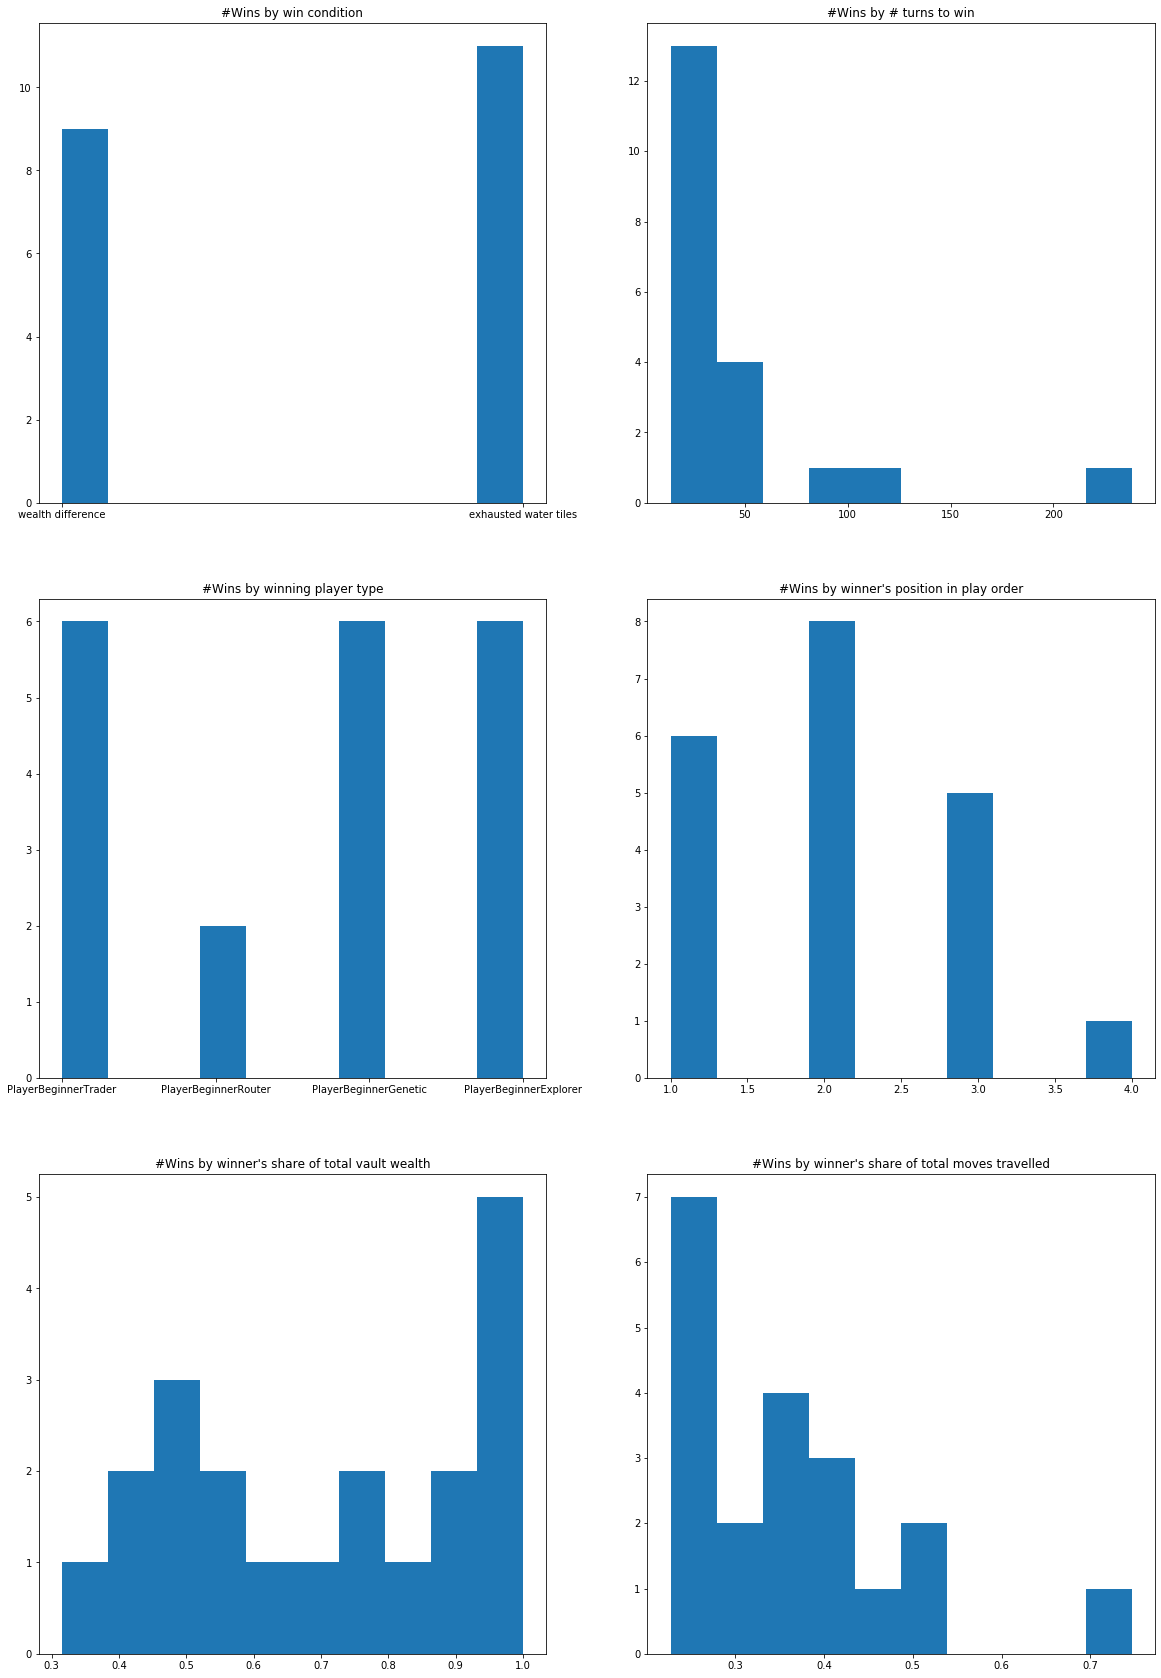

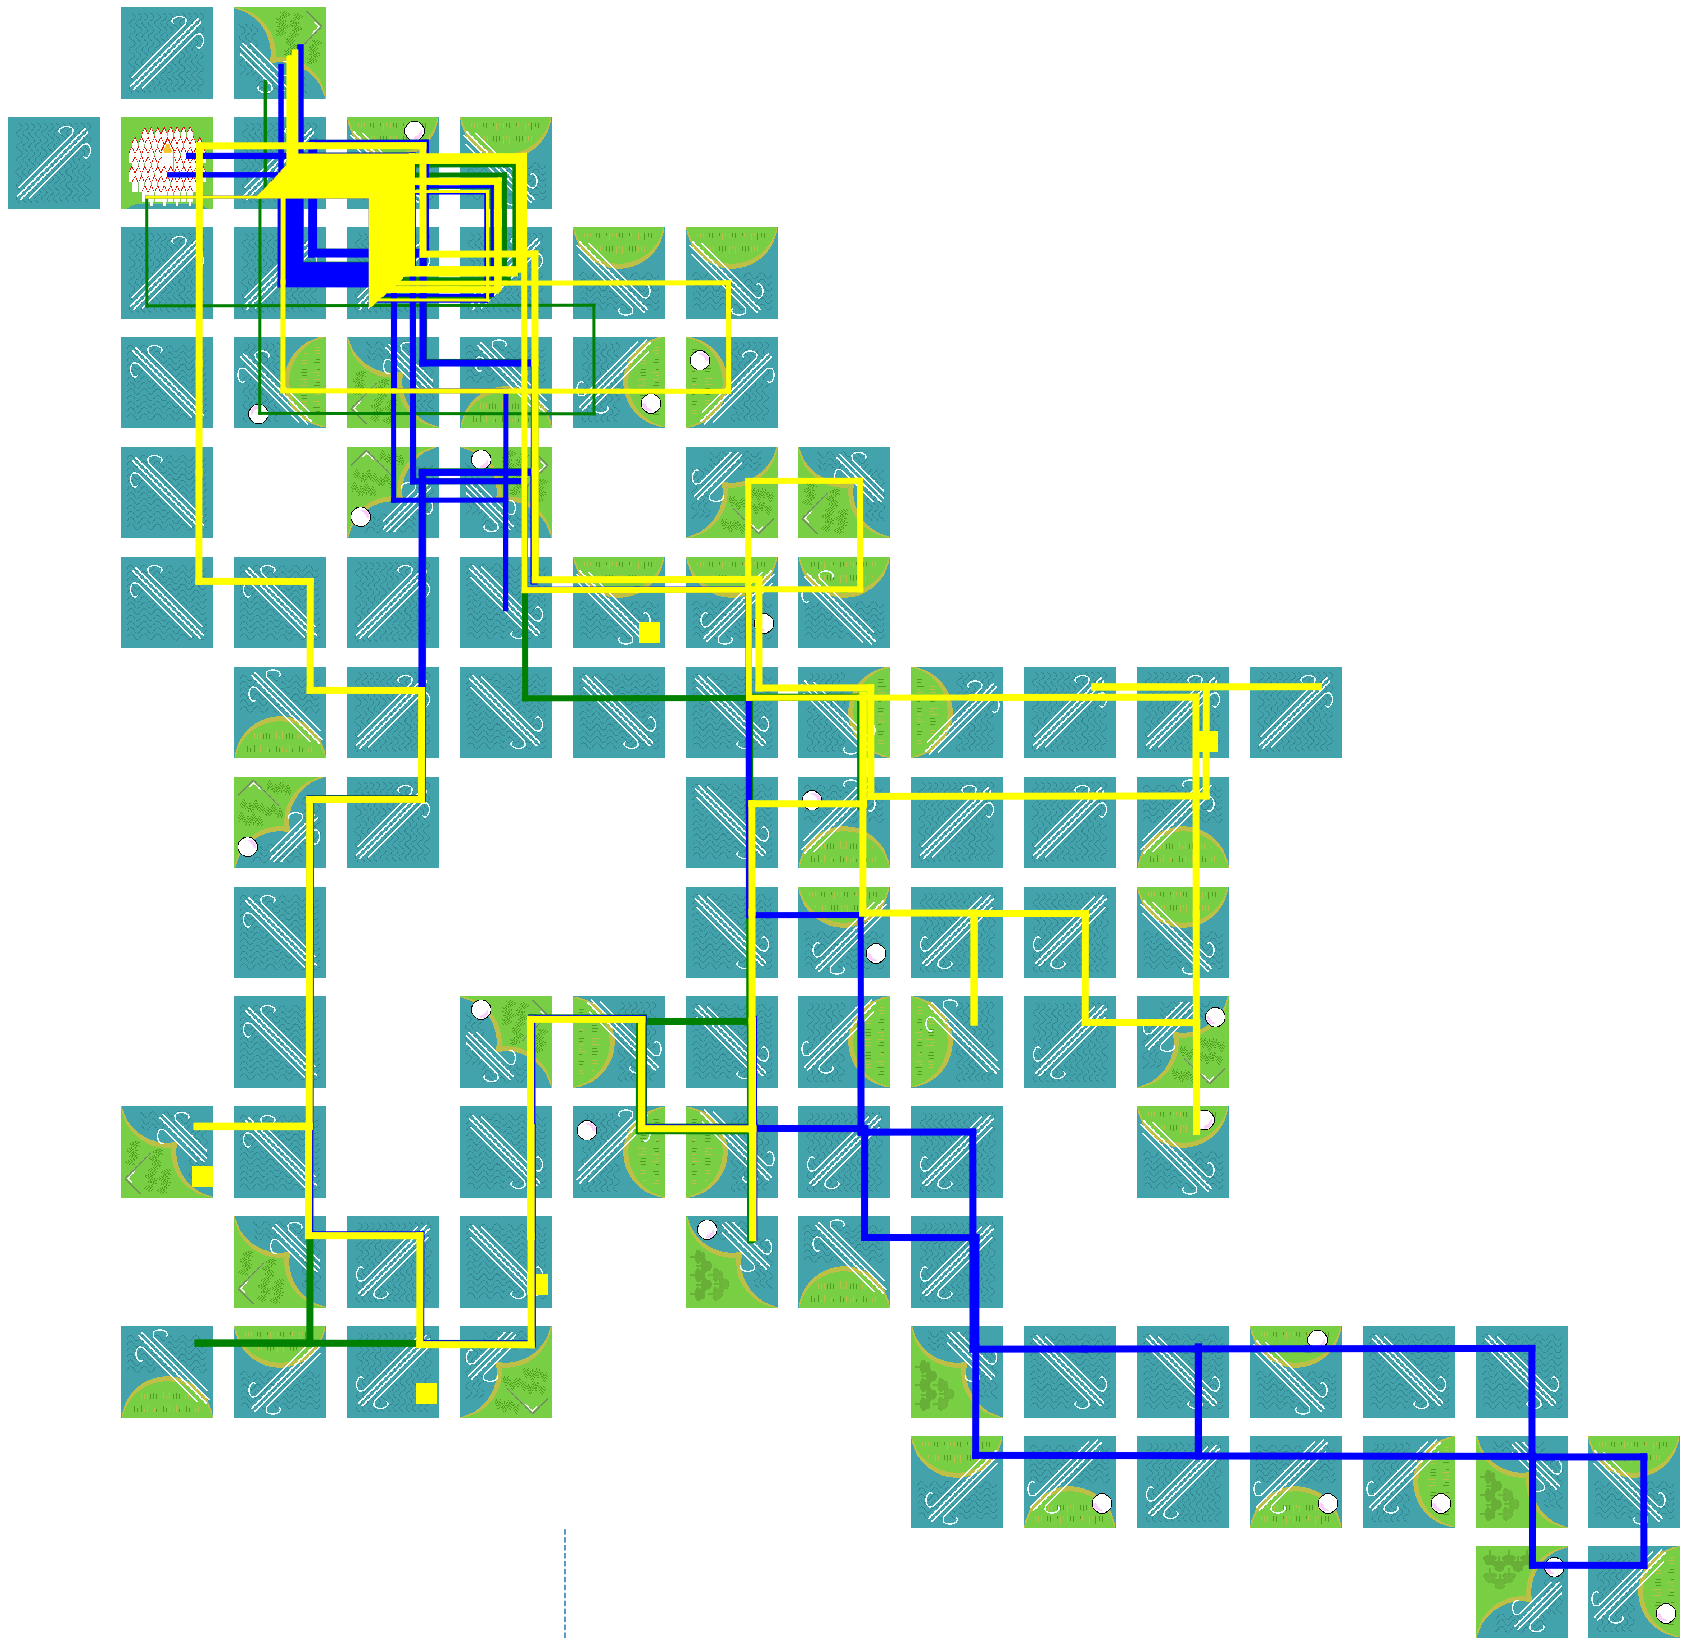

In [27]:
import random
import pandas
import sys, os # for logging

os.chdir('/home/tom/cartolan_sim')
#determine logging
stdout_backup = sys.stdout
# sys.stdout = open(os.devnull, 'w')
sys.stdout = open("./logs/cartolan_log.txt", 'w')
# sys.stdout = sys.__stdout__

player_set = {"blue":"Explorer", "red":"Trader", "yellow":"Router", "green":"Genetic"}
game_mode = "Beginner"
movement_rules = "initial" #"budgetted"
exploration_rules = "clockwise" #,"continuous"
num_players_options = [2, 3, 4]

num_games = 20

#visuals parameters
dimensions = [21,33]
origin = [10, 10]

#data to collect from each simulation
sim_stats = pandas.DataFrame(columns = ["simulation_id", "win_type", "turns"
                                        , "max_wealth_final", "wealth_difference_final"
                                        , "winning_player_type", "winning_player_order", "winning_player_route"
                                        , "failed_explorations"
                                        , "wealth_p1", "wealth_p2", "wealth_p3", "wealth_p4"
                                        , "num_adventurers_p1", "num_adventurers_p2"
                                        , "num_adventurers_p3", "num_adventurers_p4"
                                        , "num_agents_p1", "num_agents_p2", "num_agents_p3", "num_agents_p4"
                                        , "avg_route_p1", "avg_route_p2", "avg_route_p3", "avg_route_p4" 
                                        , "play_area", "players"])
play_areas = {}
player_sets = {}

#Function to collect average route lengths across a player's adventurers
def avg_route_length(player):
    avg_route_length = 0
    for adventurer in player.adventurers:
        avg_route_length += len(adventurer.route)
    return avg_route_length/len(player.adventurers)

# We have arrived! Time for the actual outcomes
#@TODO multithread this: https://realpython.com/intro-to-python-threading/#starting-a-thread
for sim_id in range(0, num_games):
    players = []
    num_players = random.choice(num_players_options)
    player_colours = random.sample(list(player_set),num_players)
    for player_colour in player_colours:
        #player_colour = random.choice(player_set)
        exec("players.append(Player" +game_mode+player_set[player_colour]+ "(colour=player_colour))")
    game = setup_simulation(players, game_mode, movement_rules, exploration_rules)
    
    #run the game
    game.start_game()

    #record stats
    if game.wealth_difference > 0 and num_players ==2:
        sim_stats = sim_stats.append( {"simulation_id":sim_id, "win_type":game.win_type, "turns":game.turn
                            , "max_wealth_final":game.max_wealth
                            , "wealth_difference_final":game.wealth_difference
                            , "winning_player_type":type(game.winning_player).__name__
                            , "winning_player_order":game.players.index(game.winning_player)+1
                            , "winning_player_route":avg_route_length(game.winning_player)
                            , "failed_explorations":game.num_failed_explorations 
                            , "wealth_p1":game.players[0].vault_wealth
                            , "wealth_p2":game.players[1].vault_wealth
                            , "num_adventurers_p1":len(game.players[0].adventurers)
                            , "num_adventurers_p2":len(game.players[1].adventurers)
                            , "num_agents_p1":len(game.players[0].agents)
                            , "num_agents_p2":len(game.players[1].agents)
                            , "avg_route_p1":avg_route_length(players[0])
                            , "avg_route_p2":avg_route_length(players[1])
                                      }, ignore_index=True)
        play_areas[sim_id] = game.play_area
        player_sets[sim_id] = game.players
    elif game.wealth_difference > 0 and num_players ==3:
        sim_stats = sim_stats.append( {"simulation_id":sim_id, "win_type":game.win_type, "turns":game.turn
                            , "max_wealth_final":game.max_wealth
                            , "wealth_difference_final":game.wealth_difference
                            , "winning_player_type":type(game.winning_player).__name__
                            , "winning_player_order":game.players.index(game.winning_player)+1
                            , "winning_player_route":avg_route_length(game.winning_player)
                            , "failed_explorations":game.num_failed_explorations 
                            , "wealth_p1":game.players[0].vault_wealth, "wealth_p2":game.players[1].vault_wealth
                            , "wealth_p3":game.players[2].vault_wealth
                            , "num_adventurers_p1":len(game.players[0].adventurers)
                            , "num_adventurers_p2":len(game.players[1].adventurers)
                            , "num_adventurers_p3":len(game.players[2].adventurers)
                            , "num_agents_p1":len(game.players[0].agents)
                            , "num_agents_p2":len(game.players[1].agents)
                            , "num_agents_p3":len(game.players[2].agents)
                            , "avg_route_p1":avg_route_length(players[0])
                            , "avg_route_p2":avg_route_length(players[1])
                            , "avg_route_p3":avg_route_length(players[2])
                                      }, ignore_index=True)
        play_areas[sim_id] = game.play_area
        player_sets[sim_id] = game.players
    elif game.wealth_difference > 0 and num_players ==4:
        sim_stats = sim_stats.append( {"simulation_id":sim_id, "win_type":game.win_type, "turns":game.turn
                            , "max_wealth_final":game.max_wealth
                            , "wealth_difference_final":game.wealth_difference
                            , "winning_player_type":type(game.winning_player).__name__
                            , "winning_player_order":game.players.index(game.winning_player)+1
                            , "winning_player_route":avg_route_length(game.winning_player)
                            , "failed_explorations":game.num_failed_explorations 
                            , "wealth_p1":game.players[0].vault_wealth, "wealth_p2":game.players[1].vault_wealth
                            , "wealth_p3":game.players[2].vault_wealth, "wealth_p4":game.players[3].vault_wealth
                            , "num_adventurers_p1":len(game.players[0].adventurers)
                            , "num_adventurers_p2":len(game.players[1].adventurers)
                            , "num_adventurers_p3":len(game.players[2].adventurers)
                            , "num_adventurers_p4":len(game.players[3].adventurers)
                            , "num_agents_p1":len(game.players[0].agents)
                            , "num_agents_p2":len(game.players[1].agents)
                            , "num_agents_p3":len(game.players[2].agents)
                            , "num_agents_p4":len(game.players[3].agents)
                            , "avg_route_p1":avg_route_length(players[0])
                            , "avg_route_p2":avg_route_length(players[1])
                            , "avg_route_p3":avg_route_length(players[2])
                            , "avg_route_p4":avg_route_length(players[3])
                                      }, ignore_index=True)
        play_areas[sim_id] = game.play_area
        player_sets[sim_id] = game.players


# Make sure that graphical outputs go here
sys.stdout = stdout_backup
# Let's compare the performance of winning players to others
play_stats_visualisation = PlayStatsVisualisation(sim_stats)
play_stats_visualisation.win_type_comparison()
play_stats_visualisation.turns_to_win()
play_stats_visualisation.player_type_comparison()
play_stats_visualisation.player_order_comparison()
play_stats_visualisation.wealth_comparison()
play_stats_visualisation.route_comparison()
# play_stats_visualisation.agent_comparison()
# play_stats_visualisation.adventurer_comparison()


#@TODO earlier agents seem to be forgotten - likely because the routes are taken from the final list of agents where some have been deleted rather than being moved?
# Let's look at the final layout and paths of the game with the highest wealth difference:
sim_id_med_wealth_difference = sim_stats[sim_stats["wealth_difference_final"] 
                                          == sim_stats["wealth_difference_final"].median()]["simulation_id"].values[0]
#work out the ideal dimensions for the visualisation
med_play_area = play_areas[sim_id_med_wealth_difference]
h_dimension = max(med_play_area.keys())-min(med_play_area.keys())
h_origin = h_dimension - max(med_play_area.keys())
max_longitude = 0
min_longitude = 0
v_dimension = 0
for latitude in med_play_area.keys():
    if max(med_play_area[latitude].keys()) > max_longitude:
        max_longitude = max(med_play_area[latitude].keys())
    if min(med_play_area[latitude].keys()) < min_longitude:
        min_longitude = min(med_play_area[latitude].keys())
v_dimension = max_longitude - min_longitude
v_origin = v_dimension - max_longitude
dimensions = [h_dimension,v_dimension]
origin = [h_origin, v_origin]
#render the play area
play_area_vis_med_wealth_difference = PlayAreaVisualisation(dimensions, origin)
play_area_vis_med_wealth_difference.draw_play_area(med_play_area)
play_area_vis_med_wealth_difference.draw_routes(player_sets[sim_id_med_wealth_difference])